# LIBRARIES

In [1]:
import matplotlib
import yfinance as yf
import pandas as pd 
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from warnings import filterwarnings
import seaborn as sns
import statsmodels.api as sm 
import statsmodels.formula.api as smf


from sklearn.preprocessing import scale, MinMaxScaler
from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score
# from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.neighbors import kneighbors_graph, KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, BaggingRegressor
import xgboost as xgb
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

from sklearn import model_selection

from skompiler import skompile

from warnings import filterwarnings
filterwarnings("ignore")

plt.rcParams["figure.figsize"] = (50,20)

import talib as talib
from talib import MA_Type



# DATA PREPERATION

## First Dataset

In [2]:
past_vals_df = yf.download(tickers='BTC-USD', start="2021-08-20", end="2021-08-21", interval = "1m")

[*********************100%***********************]  1 of 1 completed


### First glance

In [3]:
past_vals_df.head()

,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2021-08-19 22:00:00+01:00,46566.136719,46566.136719,46566.136719,46566.136719,46566.136719,0
2021-08-19 22:01:00+01:00,46575.082031,46575.082031,46575.082031,46575.082031,46575.082031,2609152
2021-08-19 22:02:00+01:00,46559.250000,46559.250000,46559.250000,46559.250000,46559.250000,0
2021-08-19 22:03:00+01:00,46530.125000,46530.125000,46530.125000,46530.125000,46530.125000,0
2021-08-19 22:04:00+01:00,46532.488281,46532.488281,46532.488281,46532.488281,46532.488281,0


In [4]:
past_vals_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,1435.0,4.744842e+04,7.413201e+02,46362.34375,46994.482422,47139.382812,4.833615e+04,4.894803e+04
High,1435.0,4.744842e+04,7.413201e+02,46362.34375,46994.482422,47139.382812,4.833615e+04,4.894803e+04
Low,1435.0,4.744842e+04,7.413201e+02,46362.34375,46994.482422,47139.382812,4.833615e+04,4.894803e+04
Close,1435.0,4.744842e+04,7.413201e+02,46362.34375,46994.482422,47139.382812,4.833615e+04,4.894803e+04
Adj Close,1435.0,4.744842e+04,7.413201e+02,46362.34375,46994.482422,47139.382812,4.833615e+04,4.894803e+04
Volume,1435.0,5.811078e+06,1.379009e+07,0.00000,0.000000,0.000000,6.361088e+06,1.657242e+08


In [5]:
past_vals_df.isnull().values.any()

False

### Visualization

<AxesSubplot:title={'center':'BTC values in between 2012-01-01 and 2021-07-01'}, xlabel='Datetime'>

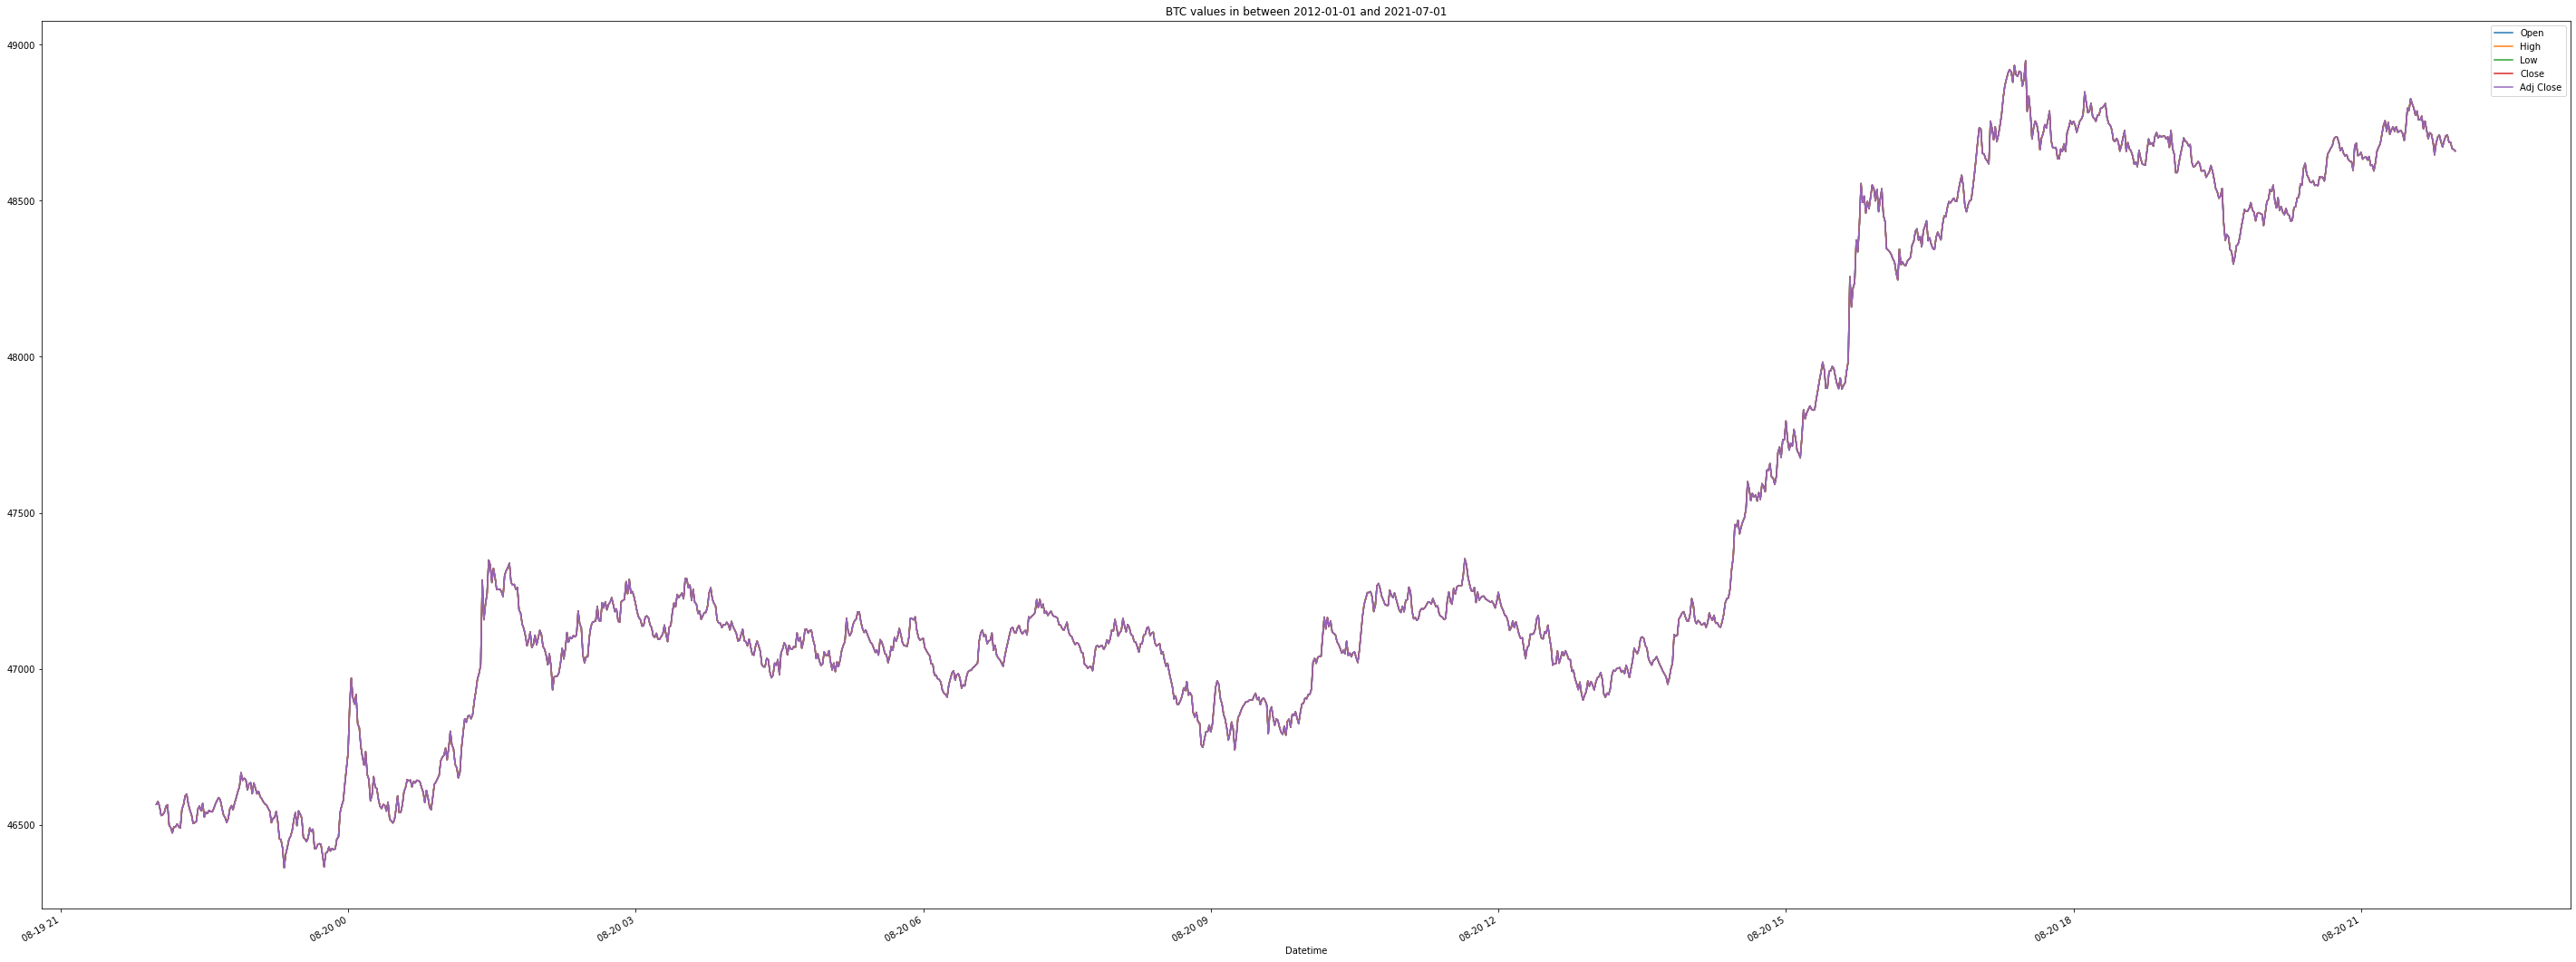

In [6]:
# To visualize the dataset better, drop "Volume"
visual_past_vals_df = past_vals_df.drop(["Volume"], axis = 1)
visual_past_vals_df.plot(title = "BTC values in between 2012-01-01 and 2021-07-01")

## Second Dataset

### Calculation

In [7]:
df = past_vals_df.copy()
close_ind = df["Close"]
open_ind = df["Open"]
high_ind = df["High"]
low_ind = df["Low"]
volume_ind = df["Volume"]

In [8]:
# SAR
df["sar_fast"] = talib.SAR(high_ind, low_ind, acceleration = 0.01, maximum = 0.1)
df["sar_mid"] = talib.SAR(high_ind, low_ind, acceleration = 0.001, maximum = 0.1)
df["sar_slow"] = talib.SAR(high_ind, low_ind, acceleration = 0.0001, maximum = 0.1)

In [9]:
# RSI
rsi_period = 14

rsi = talib.RSI(close_ind, rsi_period)
df["rsi"] = rsi

In [10]:
# MACD
macd_short_period = 12
macd_long_period = 26

macd = talib.MACD(close_ind, macd_short_period, macd_long_period)

df["macd"], df["macd_signal"], df["macd_hist"] = macd

In [11]:
# OBV
df["OBV"] = talib.OBV(close_ind, volume_ind)

In [12]:
# CCI
df["CCI"] = talib.CCI(high_ind, low_ind, close_ind, timeperiod=14)

In [13]:
# MFI
df["MFI"] = talib.MFI(high_ind, low_ind, close_ind, volume_ind, timeperiod=14)

In [14]:
# BBANDS
df["BBANDS_upper"], df["BBANDS_middle"], df["BBANDS_lower"] = talib.BBANDS(close_ind, matype=MA_Type.T3)

In [15]:
# Stochastic
df["STOCH_slow"], df["STOCH_fast"] = talib.STOCH(high_ind, low_ind, close_ind, 3, 5)

### First glance

In [16]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,sar_fast,sar_mid,sar_slow,rsi,...,macd_signal,macd_hist,OBV,CCI,MFI,BBANDS_upper,BBANDS_middle,BBANDS_lower,STOCH_slow,STOCH_fast
Datetime,,,,,,,,,,,,,,,,,,,,,
2021-08-19 22:00:00+01:00,46566.136719,46566.136719,46566.136719,46566.136719,46566.136719,0,NaN,NaN,NaN,NaN,...,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-19 22:01:00+01:00,46575.082031,46575.082031,46575.082031,46575.082031,46575.082031,2609152,46566.136719,46566.136719,46566.136719,NaN,...,NaN,NaN,2609152.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-19 22:02:00+01:00,46559.250000,46559.250000,46559.250000,46559.250000,46559.250000,0,46575.082031,46575.082031,46575.082031,NaN,...,NaN,NaN,2609152.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-19 22:03:00+01:00,46530.125000,46530.125000,46530.125000,46530.125000,46530.125000,0,46575.082031,46575.082031,46575.082031,NaN,...,NaN,NaN,2609152.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-19 22:04:00+01:00,46532.488281,46532.488281,46532.488281,46532.488281,46532.488281,0,46574.182891,46574.992117,46575.073040,NaN,...,NaN,NaN,2609152.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df = df.dropna(axis = 0, how = 'any')
df.head()

,Open,High,Low,Close,Adj Close,Volume,sar_fast,sar_mid,sar_slow,rsi,...,macd_signal,macd_hist,OBV,CCI,MFI,BBANDS_upper,BBANDS_middle,BBANDS_lower,STOCH_slow,STOCH_fast
Datetime,,,,,,,,,,,,,,,,,,,,,
2021-08-19 22:33:00+01:00,46547.105469,46547.105469,46547.105469,46547.105469,46547.105469,9711616,46528.340625,46478.104414,46474.910479,49.891855,...,6.338596,-1.739957,42446848.0,32.529669,70.871360,46571.904901,46543.138063,46514.371225,62.256384,50.520061
2021-08-19 22:34:00+01:00,46542.792969,46542.792969,46542.792969,46542.792969,46542.792969,8040448,46531.165125,46478.346111,46474.935287,48.982084,...,5.913618,-1.699913,34406400.0,24.389368,59.194796,46557.800864,46543.073630,46528.346396,53.674962,52.729243
2021-08-19 22:35:00+01:00,46541.972656,46541.972656,46541.972656,46541.972656,46541.972656,3731456,46533.876645,46478.587326,46474.960091,48.799798,...,5.490627,-1.691965,30674944.0,22.941365,54.990239,46549.467185,46542.971097,46536.475009,53.674962,56.535436
2021-08-19 22:36:00+01:00,46553.394531,46553.394531,46553.394531,46553.394531,46553.394531,2494464,46536.479704,46478.828057,46474.984890,51.505933,...,5.260770,-0.919428,33169408.0,66.068531,57.031024,46555.117578,46544.140191,46533.162803,66.627548,57.992491
2021-08-19 22:37:00+01:00,46567.917969,46567.917969,46567.917969,46567.917969,46567.917969,0,46538.978641,46479.068307,46475.009683,54.778858,...,5.383738,0.491872,33169408.0,124.613291,57.031024,46566.972560,46547.887336,46528.802111,71.418578,63.907029


## Final Dataset

In [18]:
df["Close_change"] = df["Close"].pct_change()
df["Close_change_shifted"] = df["Close_change"].shift(-1)
df.drop(columns = "Close_change", inplace = True)
df.drop(df.index[-1], inplace=True)

In [19]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume,sar_fast,sar_mid,sar_slow,rsi,...,macd_hist,OBV,CCI,MFI,BBANDS_upper,BBANDS_middle,BBANDS_lower,STOCH_slow,STOCH_fast,Close_change_shifted
Datetime,,,,,,,,,,,,,,,,,,,,,
2021-08-20 21:54:00+01:00,48710.621094,48710.621094,48710.621094,48710.621094,48710.621094,708608,48753.043455,48591.436746,48534.941429,49.552007,...,-1.524908,3.245689e+09,56.804213,89.132719,48718.700778,48690.825801,48662.950824,60.0,60.000000,-0.000478
2021-08-20 21:55:00+01:00,48687.335938,48687.335938,48687.335938,48687.335938,48687.335938,0,48747.737180,48594.962636,48536.924241,45.423173,...,-1.642838,3.245689e+09,-33.403116,89.132719,48721.675212,48693.479051,48665.282890,60.0,60.000000,-0.000009
2021-08-20 21:56:00+01:00,48686.910156,48686.910156,48686.910156,48686.910156,48686.910156,0,48742.696220,48598.435638,48538.897536,45.348764,...,-1.579048,3.245689e+09,-31.225080,89.132719,48714.117046,48693.894676,48673.672307,60.0,60.000000,-0.000419
2021-08-20 21:57:00+01:00,48666.527344,48666.527344,48666.527344,48666.527344,48666.527344,0,48737.907307,48601.856545,48540.861359,41.817228,...,-2.674717,3.245689e+09,-112.771523,89.132719,48722.478946,48690.506900,48658.534853,40.0,53.333333,-0.000049
2021-08-20 21:58:00+01:00,48664.164062,48664.164062,48664.164062,48664.164062,48664.164062,0,48733.357840,48605.226138,48542.815756,41.414523,...,-3.283614,3.245689e+09,-105.890777,100.000000,48718.377436,48684.636149,48650.894862,20.0,40.000000,-0.000100


In [20]:
df["Close_shifted"] = df["Close"].shift(-1)
df.drop(columns = ["Close", "Adj Close"], inplace = True)
df.drop(df.index[-1], inplace=True)

In [21]:
df.head()

,Open,High,Low,Volume,sar_fast,sar_mid,sar_slow,rsi,macd,macd_signal,...,OBV,CCI,MFI,BBANDS_upper,BBANDS_middle,BBANDS_lower,STOCH_slow,STOCH_fast,Close_change_shifted,Close_shifted
Datetime,,,,,,,,,,,,,,,,,,,,,
2021-08-19 22:33:00+01:00,46547.105469,46547.105469,46547.105469,9711616,46528.340625,46478.104414,46474.910479,49.891855,4.598639,6.338596,...,42446848.0,32.529669,70.871360,46571.904901,46543.138063,46514.371225,62.256384,50.520061,-0.000093,46542.792969
2021-08-19 22:34:00+01:00,46542.792969,46542.792969,46542.792969,8040448,46531.165125,46478.346111,46474.935287,48.982084,4.213705,5.913618,...,34406400.0,24.389368,59.194796,46557.800864,46543.073630,46528.346396,53.674962,52.729243,-0.000018,46541.972656
2021-08-19 22:35:00+01:00,46541.972656,46541.972656,46541.972656,3731456,46533.876645,46478.587326,46474.960091,48.799798,3.798661,5.490627,...,30674944.0,22.941365,54.990239,46549.467185,46542.971097,46536.475009,53.674962,56.535436,0.000245,46553.394531
2021-08-19 22:36:00+01:00,46553.394531,46553.394531,46553.394531,2494464,46536.479704,46478.828057,46474.984890,51.505933,4.341342,5.260770,...,33169408.0,66.068531,57.031024,46555.117578,46544.140191,46533.162803,66.627548,57.992491,0.000312,46567.917969
2021-08-19 22:37:00+01:00,46567.917969,46567.917969,46567.917969,0,46538.978641,46479.068307,46475.009683,54.778858,5.875610,5.383738,...,33169408.0,124.613291,57.031024,46566.972560,46547.887336,46528.802111,71.418578,63.907029,0.000225,46578.406250


In [22]:
final_df = df.copy()

<AxesSubplot:>

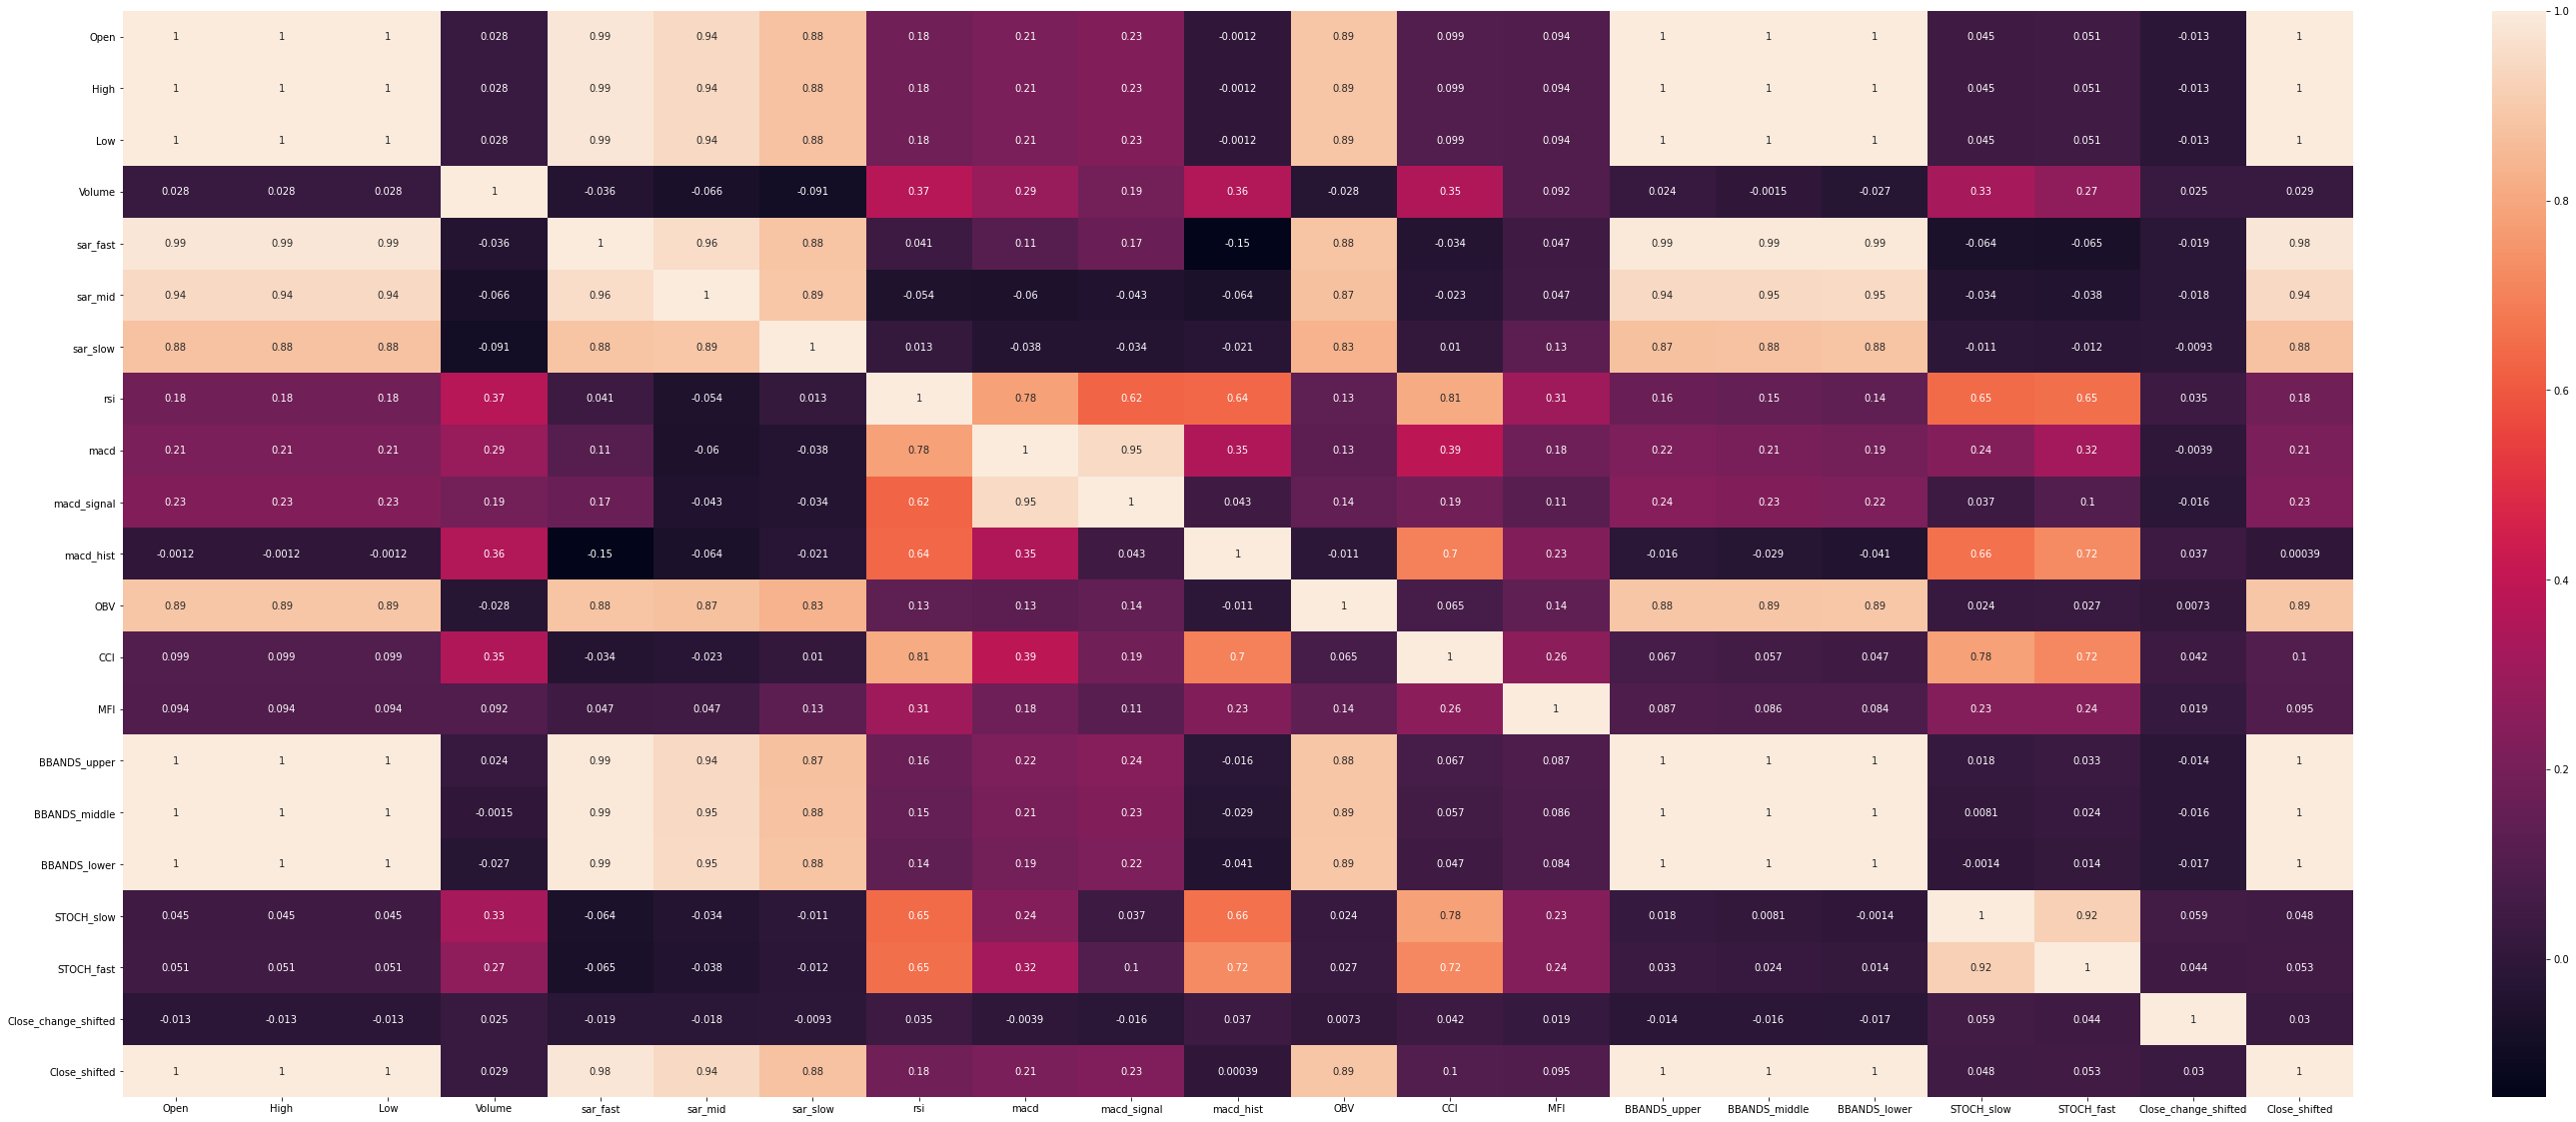

In [23]:
corr = final_df.corr()
sns.heatmap(corr, annot = True)

# MODEL TRAINING

## Arranging X and Y datasets

In [24]:
y = final_df["Close_change_shifted"][:600]
X_ = final_df.drop(["Close_change_shifted", "Close_shifted"], axis = 1)[:600]

# train_size = int (len(final_df) * 0.7)
# test_size = len(final_df) - train_size

# X_train, X_test = X_[:train_size], X_[- test_size:]
# y_train, y_test = y[:train_size], y[- test_size:]
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size = 0.3, random_state = 123)

## KNN - unscaled

In [25]:
knn_model = KNeighborsRegressor()
knn_model.fit(X_train, y_train)

KNeighborsRegressor()

### Prediction and Success Metrics

In [26]:
y_pred_knn = knn_model.predict(X_test)

In [27]:
scale = final_df["Close_change_shifted"].values.max() - final_df["Close_change_shifted"].values.min()
print("In the interval", scale, ", performance metrics are as follows")
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_knn)))
print("MSE: ", mean_squared_error(y_test, y_pred_knn))
print("MAE: ", mean_absolute_error(y_test, y_pred_knn))

In the interval 0.009118862234485992 , performance metrics are as follows
RMSE:  0.0006398130533340242
MSE:  4.0936074321660687e-07
MAE:  0.00047533238198991406


### Visualization

<AxesSubplot:title={'center':'Real Close values as y_test ; Close predictions with knn as y_pred_knn'}>

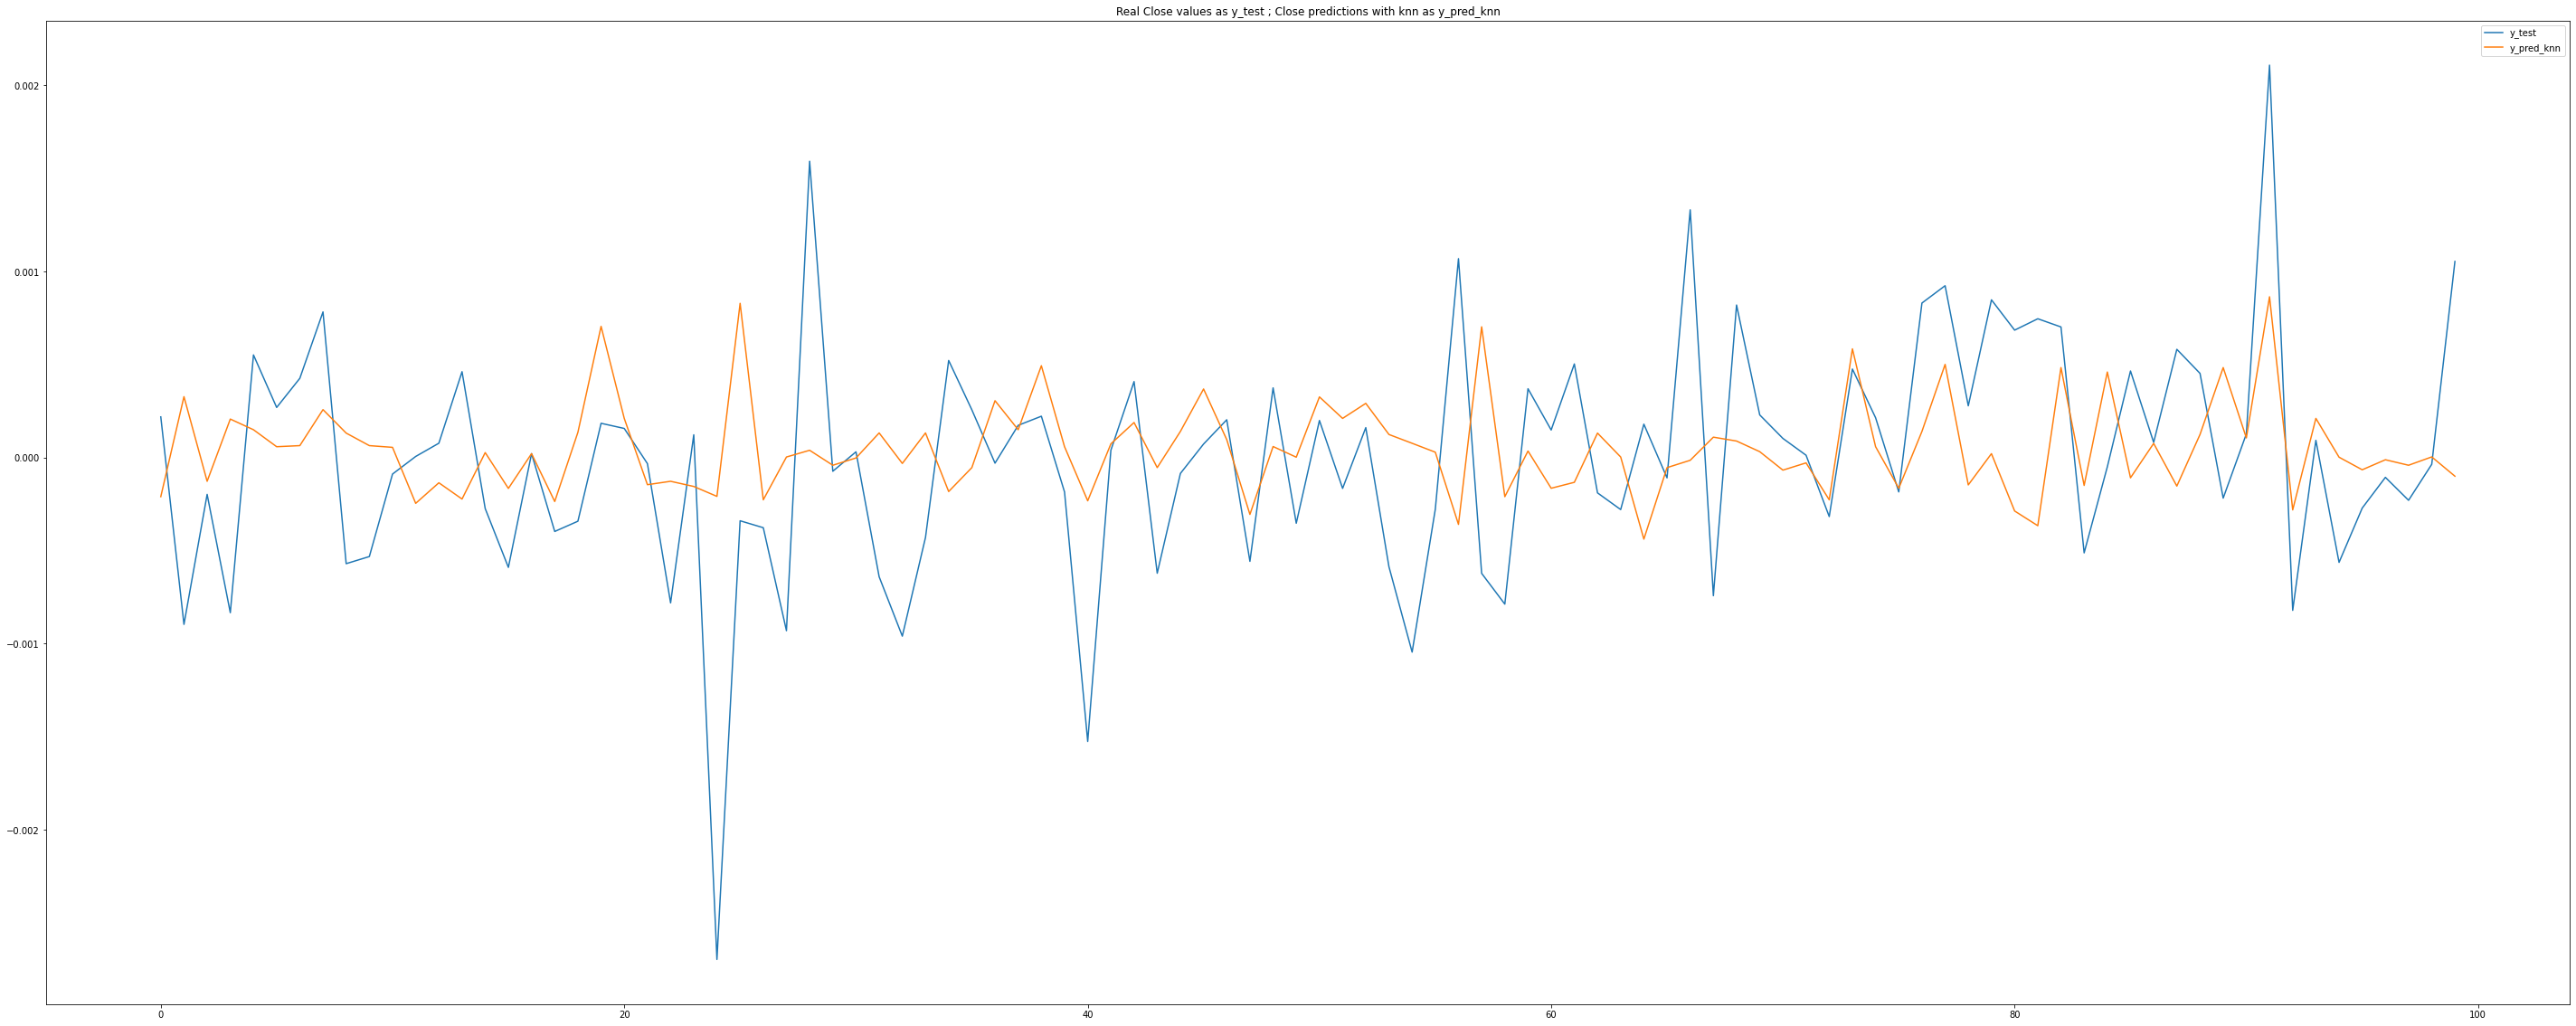

In [28]:
list_of_tuples = list(zip(y_test, y_pred_knn))
knn_res_df = pd.DataFrame(list_of_tuples, columns = ['y_test', 'y_pred_knn'])
knn_res_df[:100].plot(title ="Real Close values as y_test ; Close predictions with knn as y_pred_knn")

## CART

In [29]:
cart_model = DecisionTreeRegressor()
cart_model.fit(X_train, y_train)

DecisionTreeRegressor()

### Prediction and Success Metrics

In [30]:
y_pred_cart = cart_model.predict(X_test)

In [31]:
# code
print(skompile(cart_model.predict).to("python/code"))

((0.0032615013940247017 if x[12] <= 204.39299774169922 else 
    0.0018575730156586978) if x[6] <= 46362.431640625 else ((((
    0.0003907622722725268 if x[16] <= 46346.185546875 else 
    0.00019861527649145394) if x[16] <= 46351.419921875 else (
    0.000961094503553861 if x[16] <= 46622.779296875 else 
    0.0008189970055474394 if x[11] <= 993925120.0 else 
    0.0008403770005169786) if x[7] <= 33.88691520690918 else (
    0.0005624428039419094 if x[14] <= 46710.5859375 else 
    0.0004026961338174928 if x[1] <= 46958.625 else 0.0004048627442108099) if
    x[18] <= 38.702314376831055 else (0.0007218882916946168 if x[4] <= 
    46768.638671875 else 0.000680192878159458) if x[2] <= 47004.03125 else 
    0.0009769776382613227) if x[4] <= 47049.53125 else (((
    3.833560283972304e-05 if x[6] <= 46407.40625 else 
    2.8605079929633348e-05) if x[6] <= 46449.876953125 else 
    0.0001795463971092648) if x[11] <= 996782080.0 else 
    -0.00017001170100117147 if x[1] <= 46920.044921875 els

In [32]:
scale = final_df["Close_change_shifted"].values.max() - final_df["Close_change_shifted"].values.min()
print("In the interval", scale, ", performance metrics are as follows")
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_cart)))
print("MSE: ", mean_squared_error(y_test, y_pred_cart))
print("MAE: ", mean_absolute_error(y_test, y_pred_cart))

In the interval 0.009118862234485992 , performance metrics are as follows
RMSE:  0.0011230637495844135
MSE:  1.2612721856306024e-06
MAE:  0.0006914373859068198


### Visualization

<AxesSubplot:title={'center':'Real Close values as y_test ; Close predictions with cart as y_pred_cart'}>

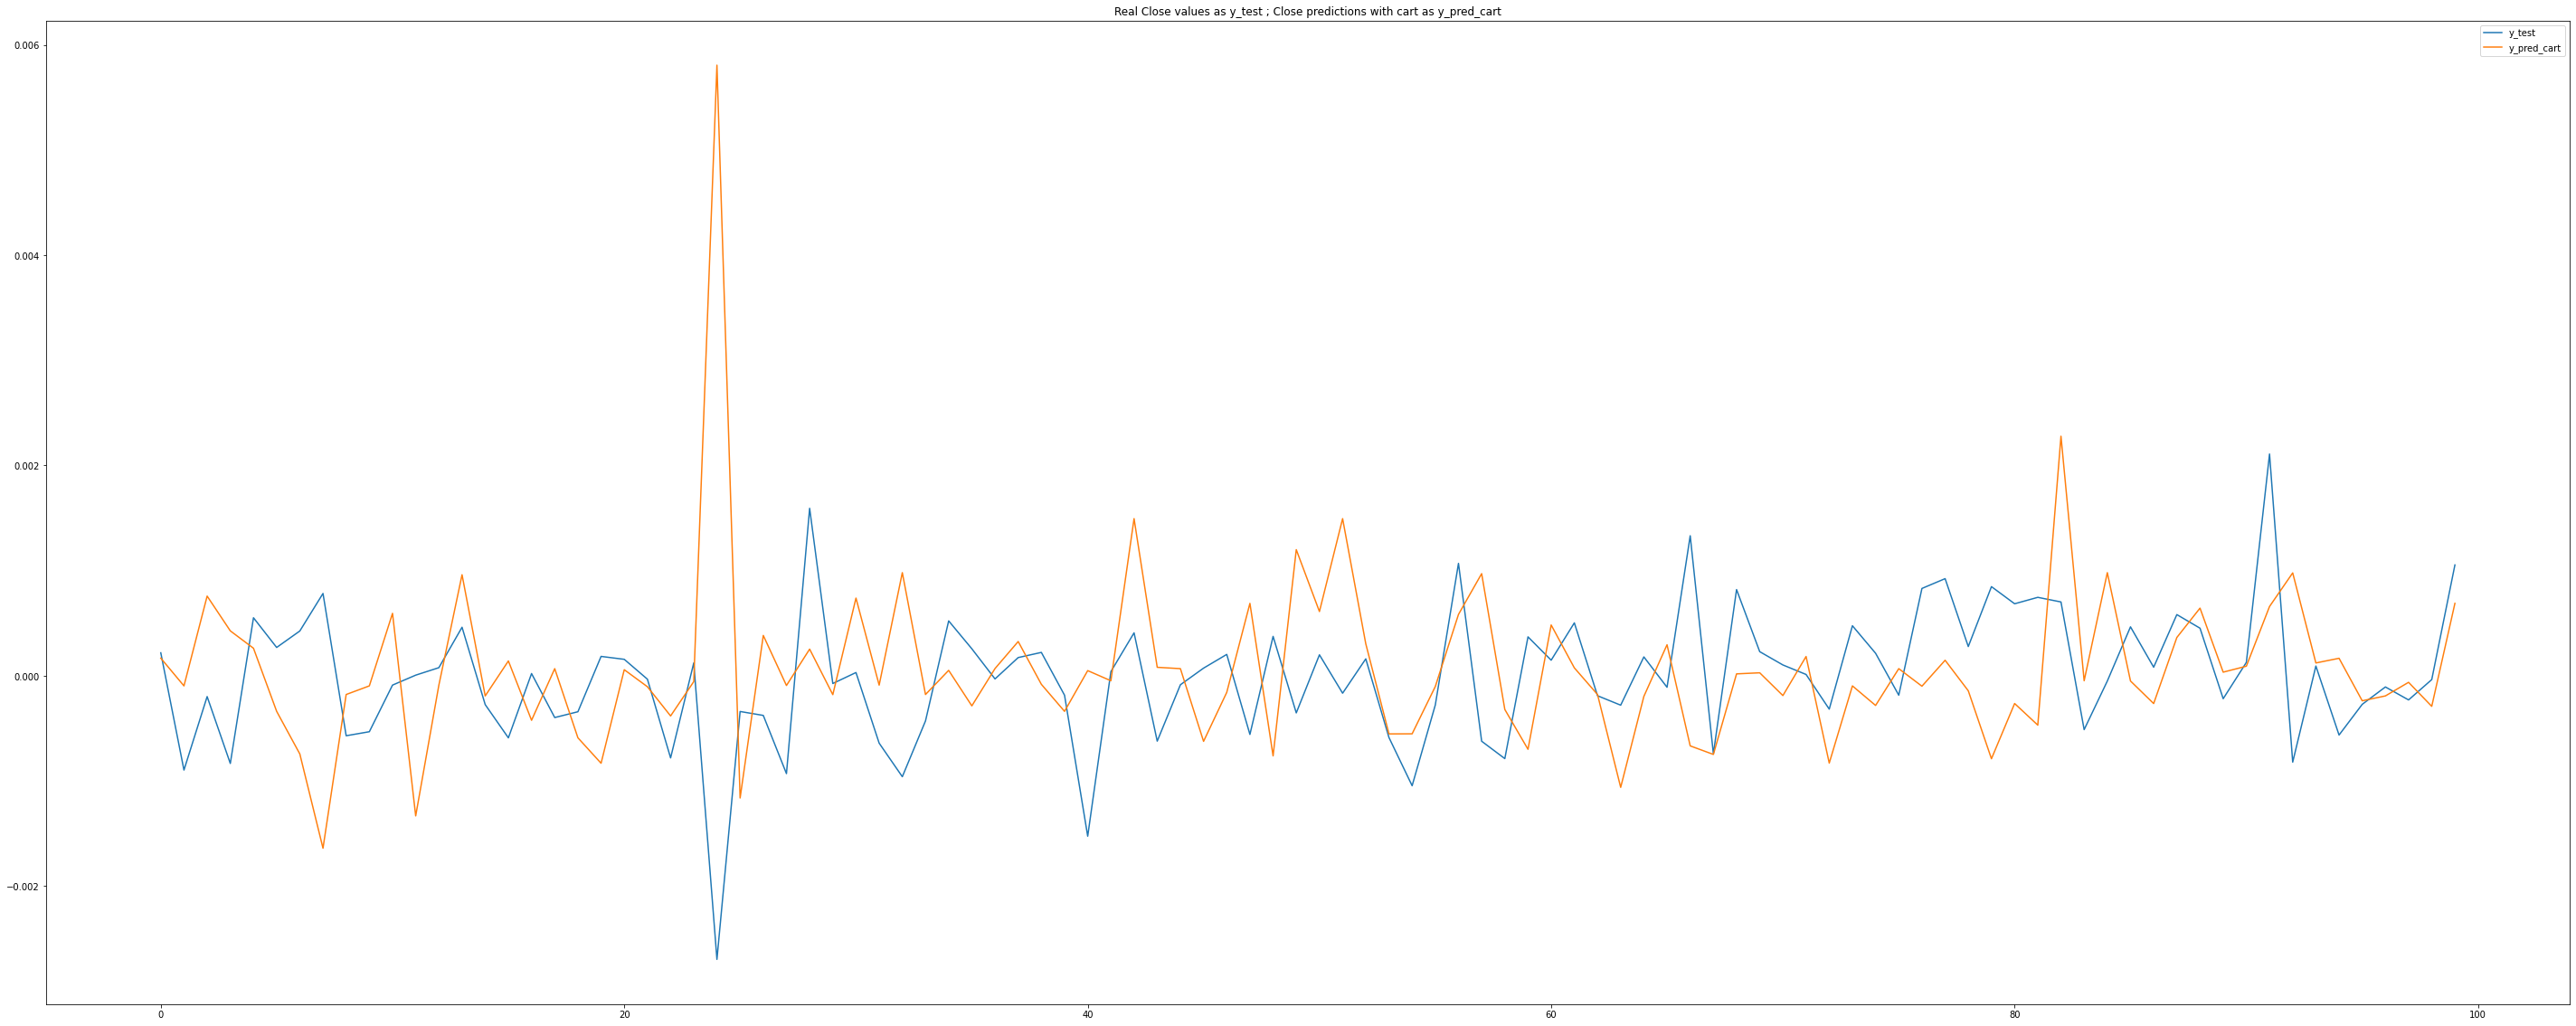

In [33]:
list_of_tuples = list(zip(y_test, y_pred_cart))
knn_res_df = pd.DataFrame(list_of_tuples, columns = ['y_test', 'y_pred_cart'])
knn_res_df[:100].plot(title ="Real Close values as y_test ; Close predictions with cart as y_pred_cart")

## Bagged Trees

In [34]:
bag_model = BaggingRegressor(bootstrap_features = True)
bag_model.fit(X_train, y_train)

BaggingRegressor(bootstrap_features=True)

### Prediction and Success Metrics

In [35]:
y_pred_bag_model = bag_model.predict(X_test)

In [36]:
scale = final_df["Close_change_shifted"].values.max() - final_df["Close_change_shifted"].values.min()
print("In the interval", scale, ", performance metrics are as follows")
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_bag_model)))
print("MSE: ", mean_squared_error(y_test, y_pred_bag_model))
print("MAE: ", mean_absolute_error(y_test, y_pred_bag_model))

In the interval 0.009118862234485992 , performance metrics are as follows
RMSE:  0.0007722858165397253
MSE:  5.964253824284303e-07
MAE:  0.0004902114261156957


### Visualization

<AxesSubplot:title={'center':'Real Close values as y_test ; Close predictions with knn as y_pred_bag_model'}>

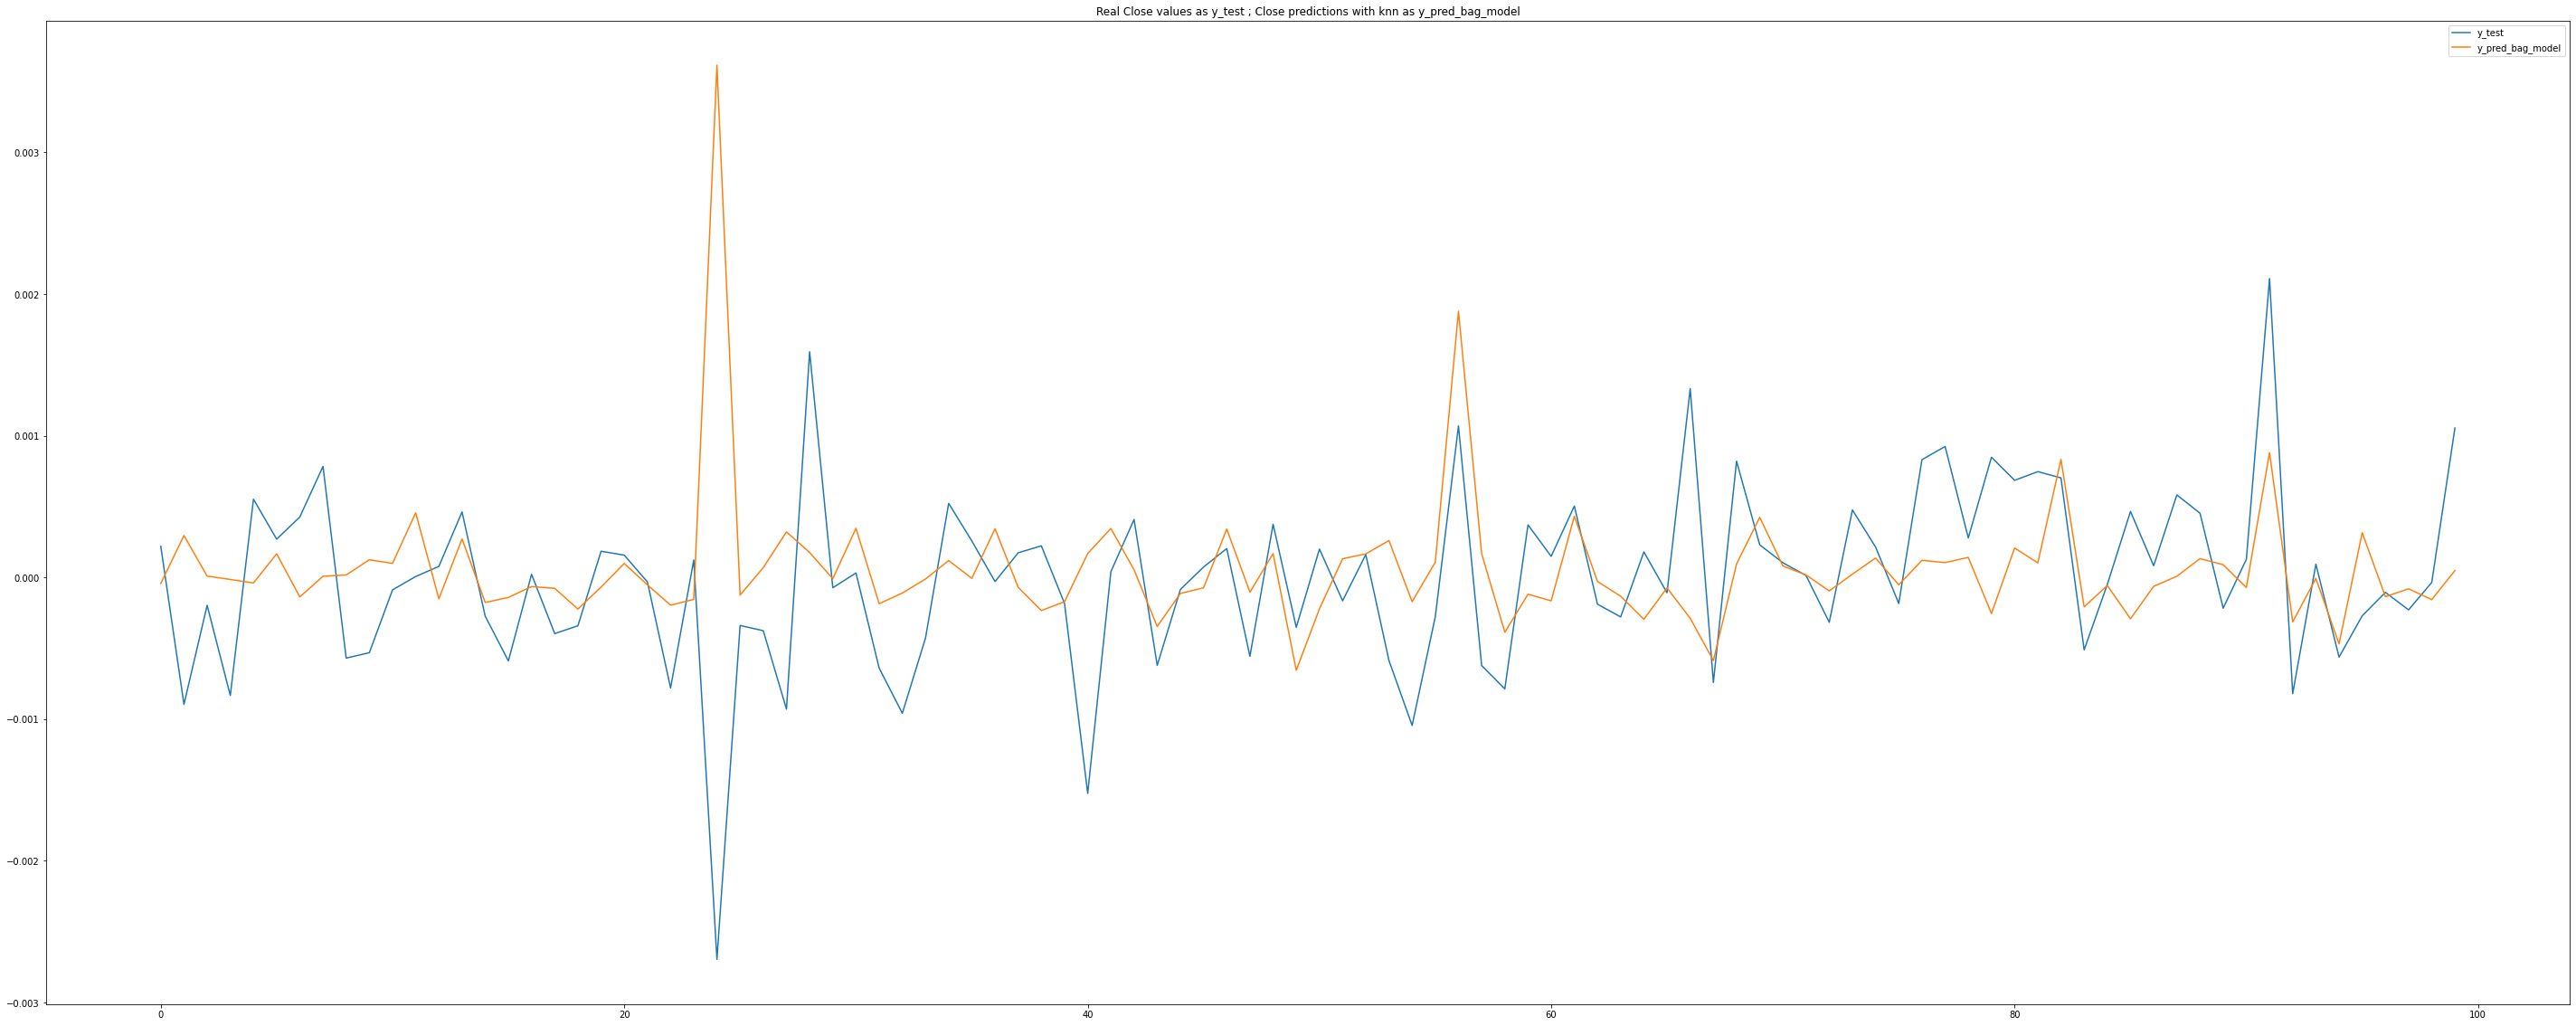

In [37]:
list_of_tuples = list(zip(y_test, y_pred_bag_model))
knn_res_df = pd.DataFrame(list_of_tuples, columns = ['y_test', 'y_pred_bag_model'])
knn_res_df[:100].plot(title ="Real Close values as y_test ; Close predictions with knn as y_pred_bag_model")

## Random Forest

In [38]:
rf_model = RandomForestRegressor(random_state = 123)
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=123)

### Prediction and Success Metrics

In [39]:
y_pred_rf_model = rf_model.predict(X_test)

In [40]:
scale = final_df["Close_change_shifted"].values.max() - final_df["Close_change_shifted"].values.min()
print("In the interval", scale, ", performance metrics are as follows")
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_rf_model)))
print("MSE: ", mean_squared_error(y_test, y_pred_rf_model))
print("MAE: ", mean_absolute_error(y_test, y_pred_rf_model))

In the interval 0.009118862234485992 , performance metrics are as follows
RMSE:  0.0006733370959804201
MSE:  4.5338284482334545e-07
MAE:  0.00046323163024559067


### Visualization

<AxesSubplot:title={'center':'Real Close values as y_test ; Close predictions with knn as y_pred_knn'}>

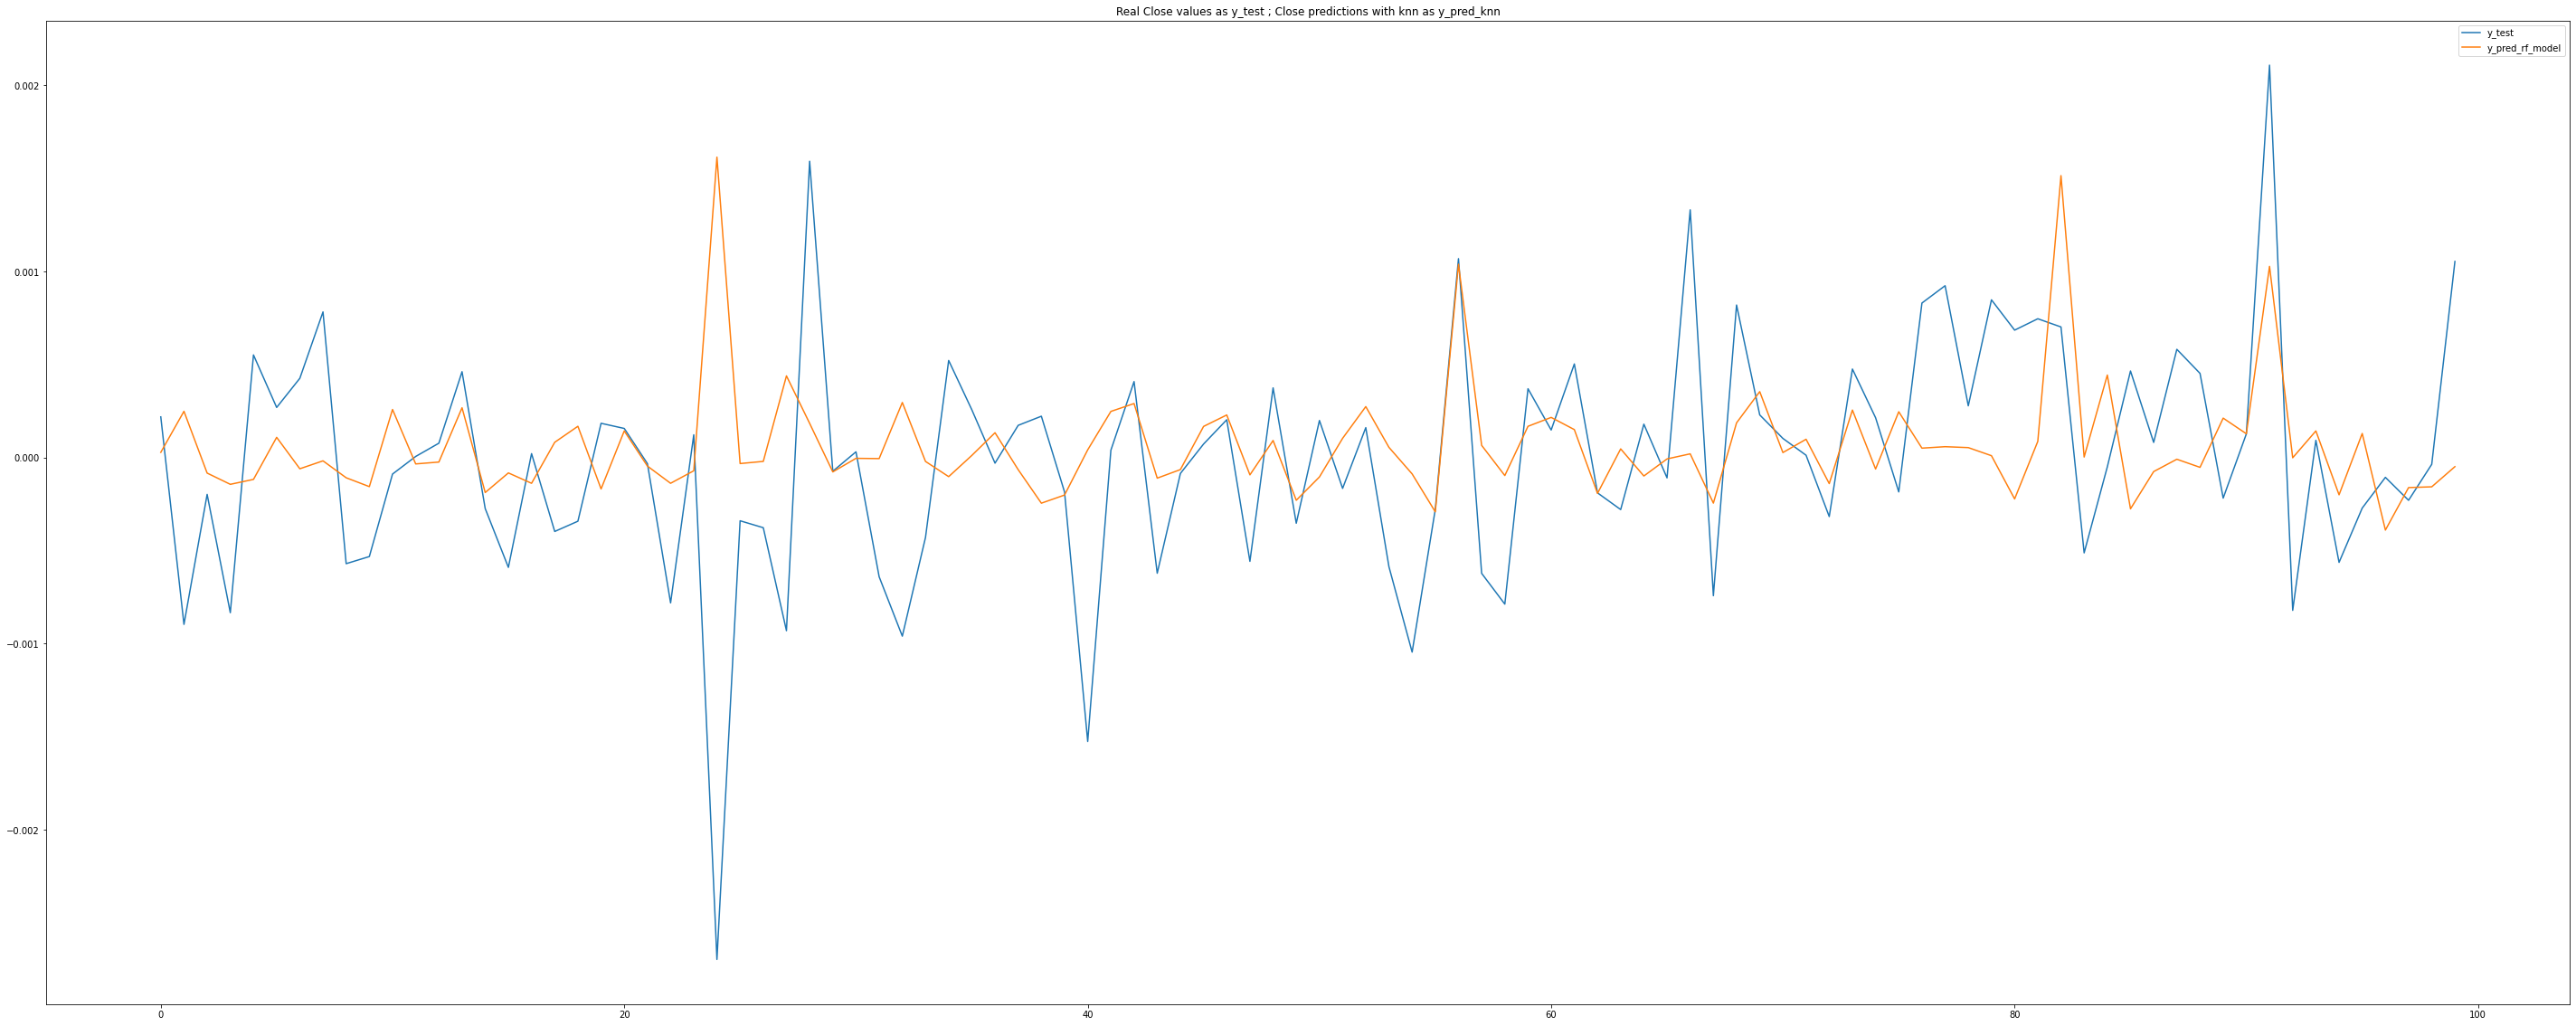

In [41]:
list_of_tuples = list(zip(y_test, y_pred_rf_model))
knn_res_df = pd.DataFrame(list_of_tuples, columns = ['y_test', 'y_pred_rf_model'])
knn_res_df[:100].plot(title ="Real Close values as y_test ; Close predictions with knn as y_pred_knn")

## GBM

In [42]:
gbm_model = GradientBoostingRegressor()
gbm_model.fit(X_train, y_train)

GradientBoostingRegressor()

### Prediction and Success Metrics

In [43]:
y_pred_gbm_model = gbm_model.predict(X_test)

In [44]:
scale = final_df["Close_change_shifted"].values.max() - final_df["Close_change_shifted"].values.min()
print("In the interval", scale, ", performance metrics are as follows")
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_gbm_model)))
print("MSE: ", mean_squared_error(y_test, y_pred_gbm_model))
print("MAE: ", mean_absolute_error(y_test, y_pred_gbm_model))

In the interval 0.009118862234485992 , performance metrics are as follows
RMSE:  0.0007480709653886933
MSE:  5.596101692575717e-07
MAE:  0.0004797896383635578


### Visualization

<AxesSubplot:title={'center':'Real Close values as y_test ; Close predictions with knn as y_pred_gbm_model'}>

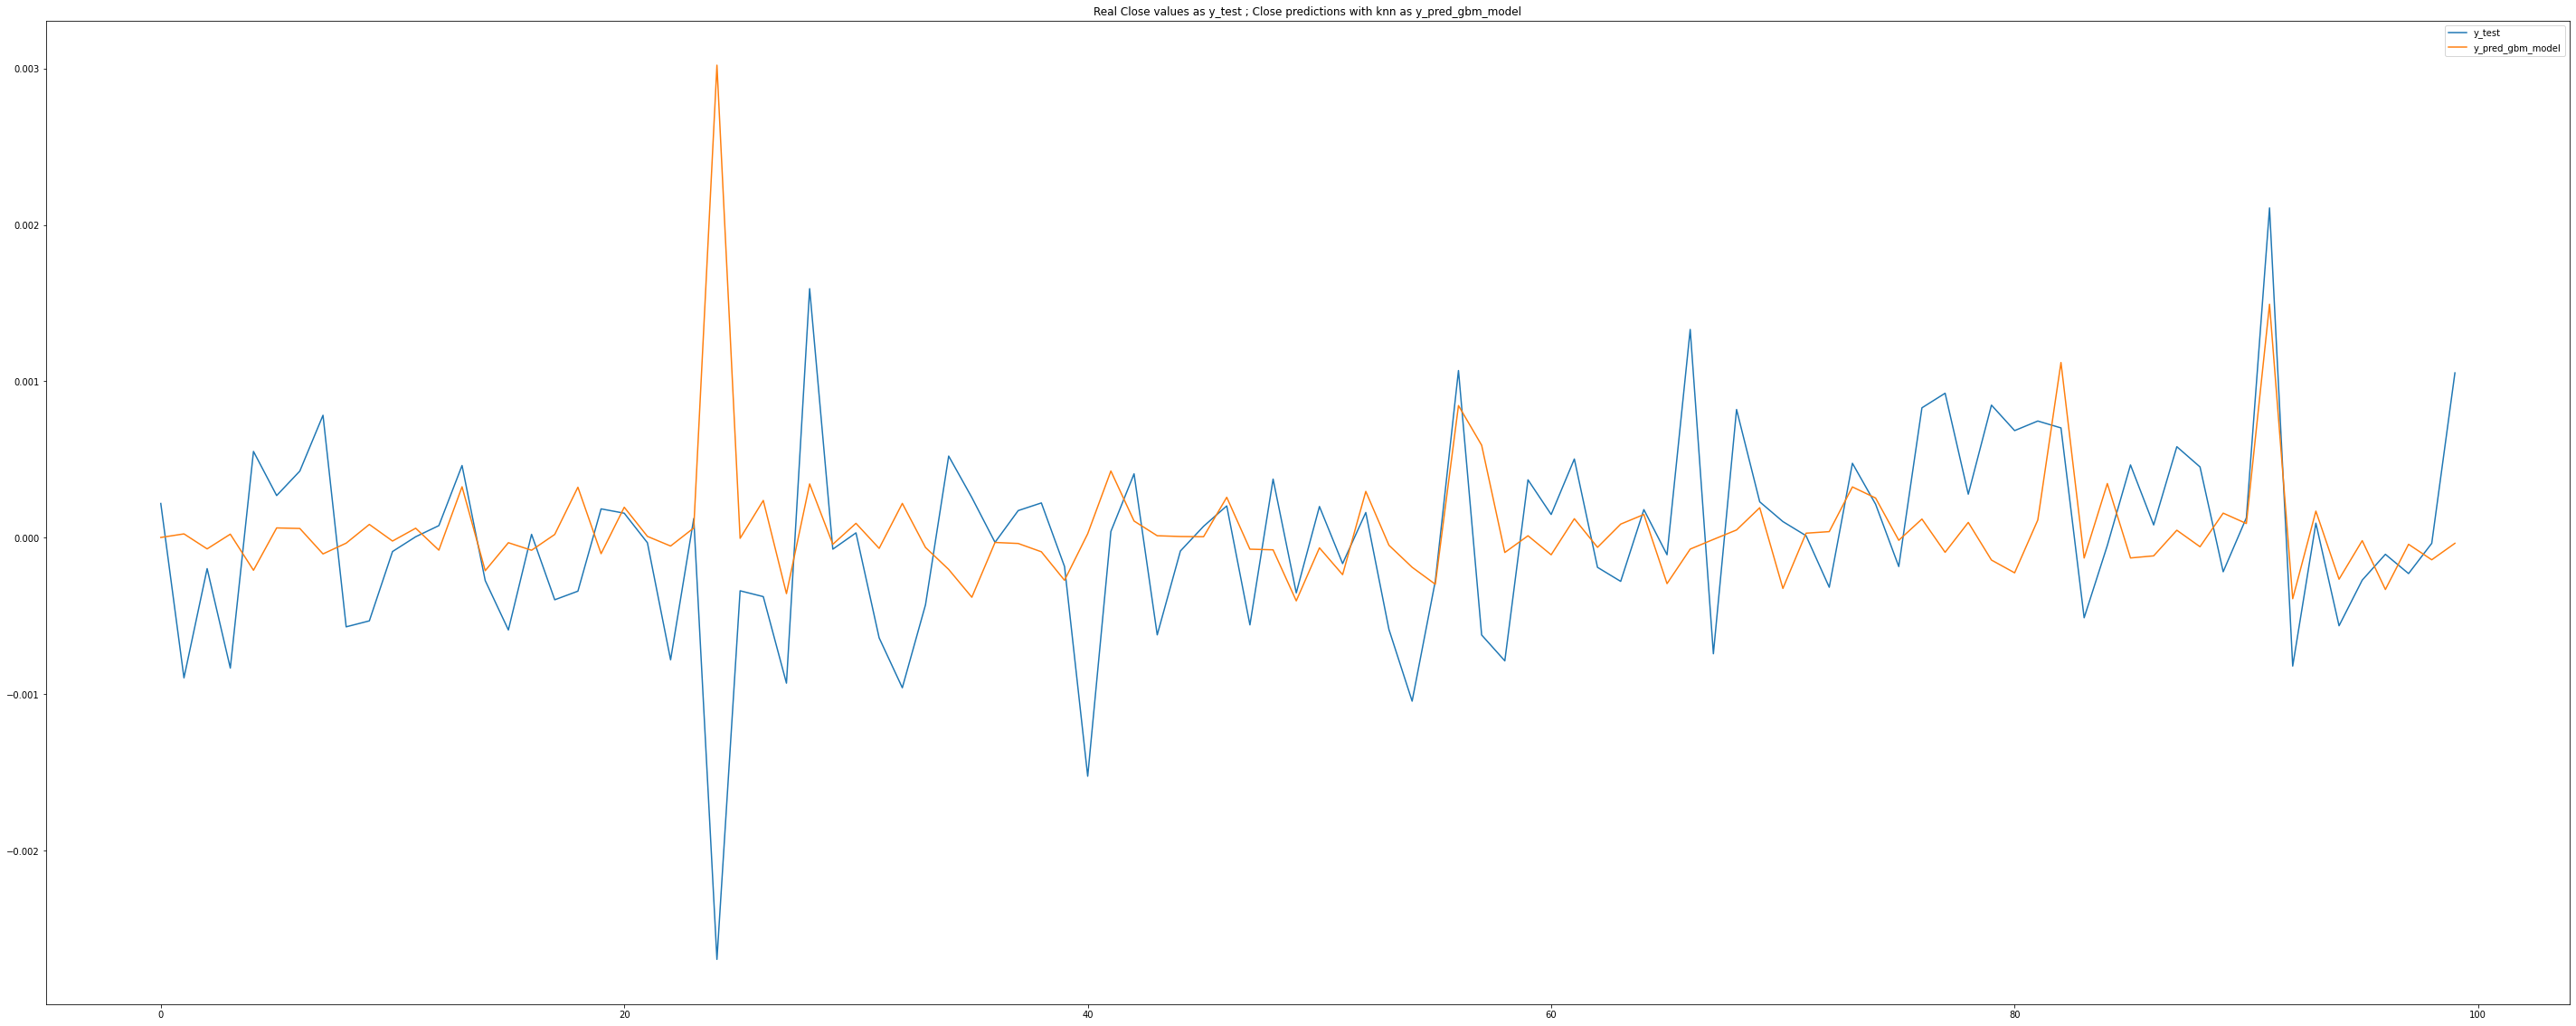

In [45]:
list_of_tuples = list(zip(y_test, y_pred_gbm_model))
knn_res_df = pd.DataFrame(list_of_tuples, columns = ['y_test', 'y_pred_gbm_model'])
knn_res_df[:100].plot(title ="Real Close values as y_test ; Close predictions with knn as y_pred_gbm_model")

## LightGBM

In [46]:
lgbm_model = LGBMRegressor()
lgbm_model.fit(X_train, y_train)

LGBMRegressor()

### Prediction and Success Metrics

In [47]:
y_pred_lgbm_model = lgbm_model.predict(X_test, num_iteration = lgbm_model.best_iteration_)

In [48]:
scale = final_df["Close_change_shifted"].values.max() - final_df["Close_change_shifted"].values.min()
print("In the interval", scale, ", performance metrics are as follows")
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_lgbm_model)))
print("MSE: ", mean_squared_error(y_test, y_pred_lgbm_model))
print("MAE: ", mean_absolute_error(y_test, y_pred_lgbm_model))

In the interval 0.009118862234485992 , performance metrics are as follows
RMSE:  0.0006822135029077299
MSE:  4.654152635496351e-07
MAE:  0.00048780034096546277


### Visualization

<AxesSubplot:title={'center':'Real Close values as y_test ; Close predictions with knn as y_pred_lgbm_model'}>

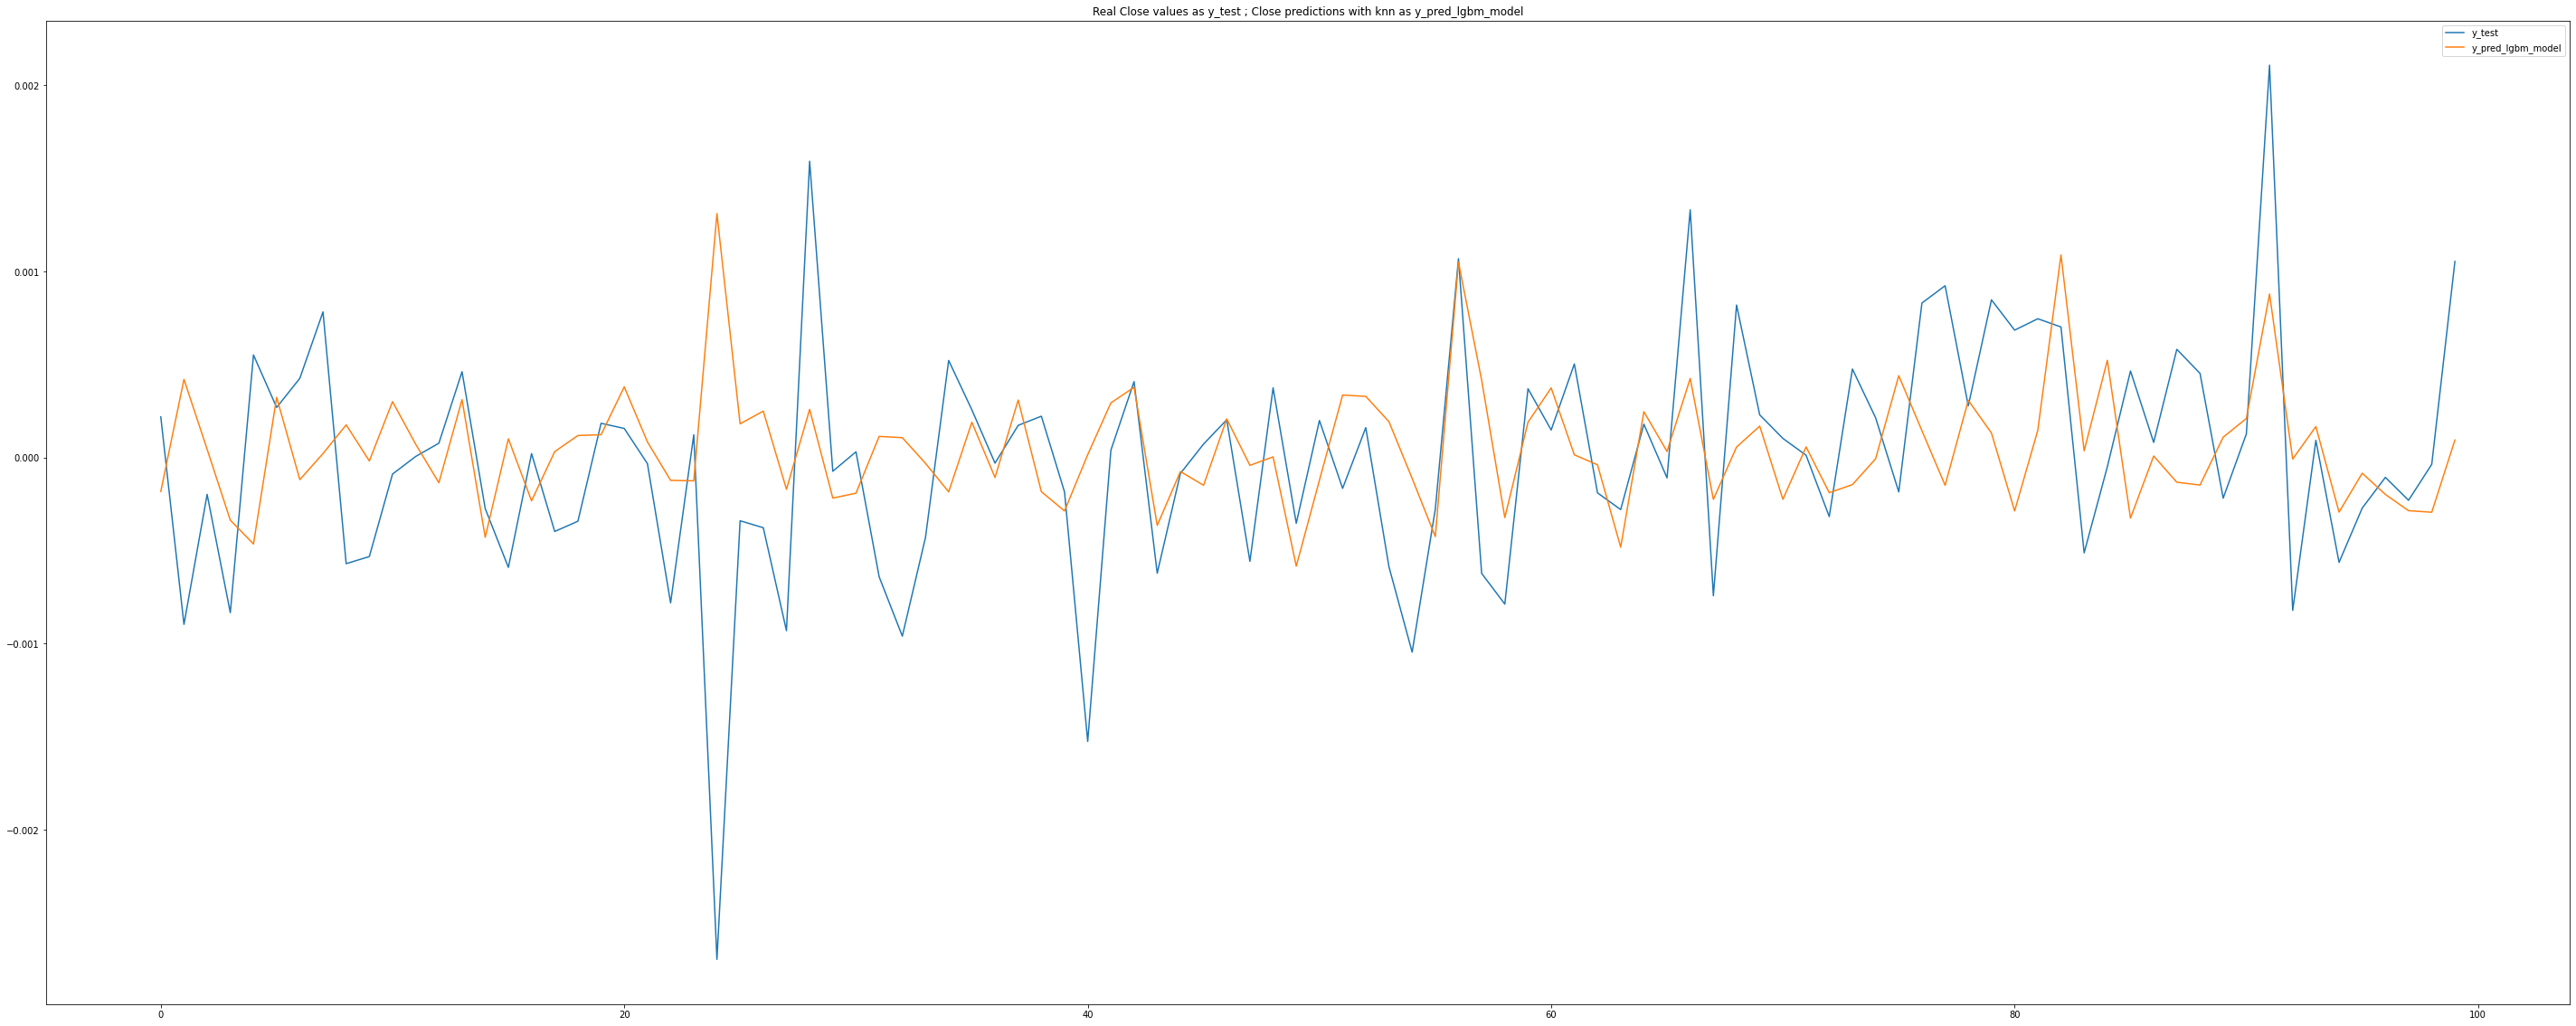

In [49]:
list_of_tuples = list(zip(y_test, y_pred_lgbm_model))
knn_res_df = pd.DataFrame(list_of_tuples, columns = ['y_test', 'y_pred_lgbm_model'])
knn_res_df[:100].plot(title ="Real Close values as y_test ; Close predictions with knn as y_pred_lgbm_model")

## CatBoost

In [50]:
catb_model = CatBoostRegressor()
catb_model.fit(X_train, y_train)

Learning rate set to 0.033446
0:	learn: 0.0006645	total: 142ms	remaining: 2m 21s
1:	learn: 0.0006624	total: 145ms	remaining: 1m 12s
2:	learn: 0.0006605	total: 148ms	remaining: 49.3s
3:	learn: 0.0006590	total: 151ms	remaining: 37.6s
4:	learn: 0.0006567	total: 154ms	remaining: 30.5s
5:	learn: 0.0006552	total: 157ms	remaining: 26.1s
6:	learn: 0.0006525	total: 160ms	remaining: 22.8s
7:	learn: 0.0006502	total: 163ms	remaining: 20.2s
8:	learn: 0.0006487	total: 166ms	remaining: 18.3s
9:	learn: 0.0006472	total: 170ms	remaining: 16.9s
10:	learn: 0.0006457	total: 173ms	remaining: 15.6s
11:	learn: 0.0006440	total: 177ms	remaining: 14.5s
12:	learn: 0.0006417	total: 180ms	remaining: 13.7s
13:	learn: 0.0006402	total: 184ms	remaining: 12.9s
14:	learn: 0.0006388	total: 188ms	remaining: 12.3s
15:	learn: 0.0006368	total: 191ms	remaining: 11.8s
16:	learn: 0.0006348	total: 194ms	remaining: 11.2s
17:	learn: 0.0006334	total: 197ms	remaining: 10.8s
18:	learn: 0.0006320	total: 200ms	remaining: 10.3s
19:	learn

### Prediction and Success Metrics

In [51]:
y_pred_catb_model = catb_model.predict(X_test)

In [52]:
scale = final_df["Close_change_shifted"].values.max() - final_df["Close_change_shifted"].values.min()
print("In the interval", scale, ", performance metrics are as follows")
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_catb_model)))
print("MSE: ", mean_squared_error(y_test, y_pred_catb_model))
print("MAE: ", mean_absolute_error(y_test, y_pred_catb_model))

In the interval 0.009118862234485992 , performance metrics are as follows
RMSE:  0.000610133834269222
MSE:  3.7226329572006246e-07
MAE:  0.00044031336553260577


### Visualization

<AxesSubplot:title={'center':'Real Close values as y_test ; Close predictions with knn as y_pred_catb_model'}>

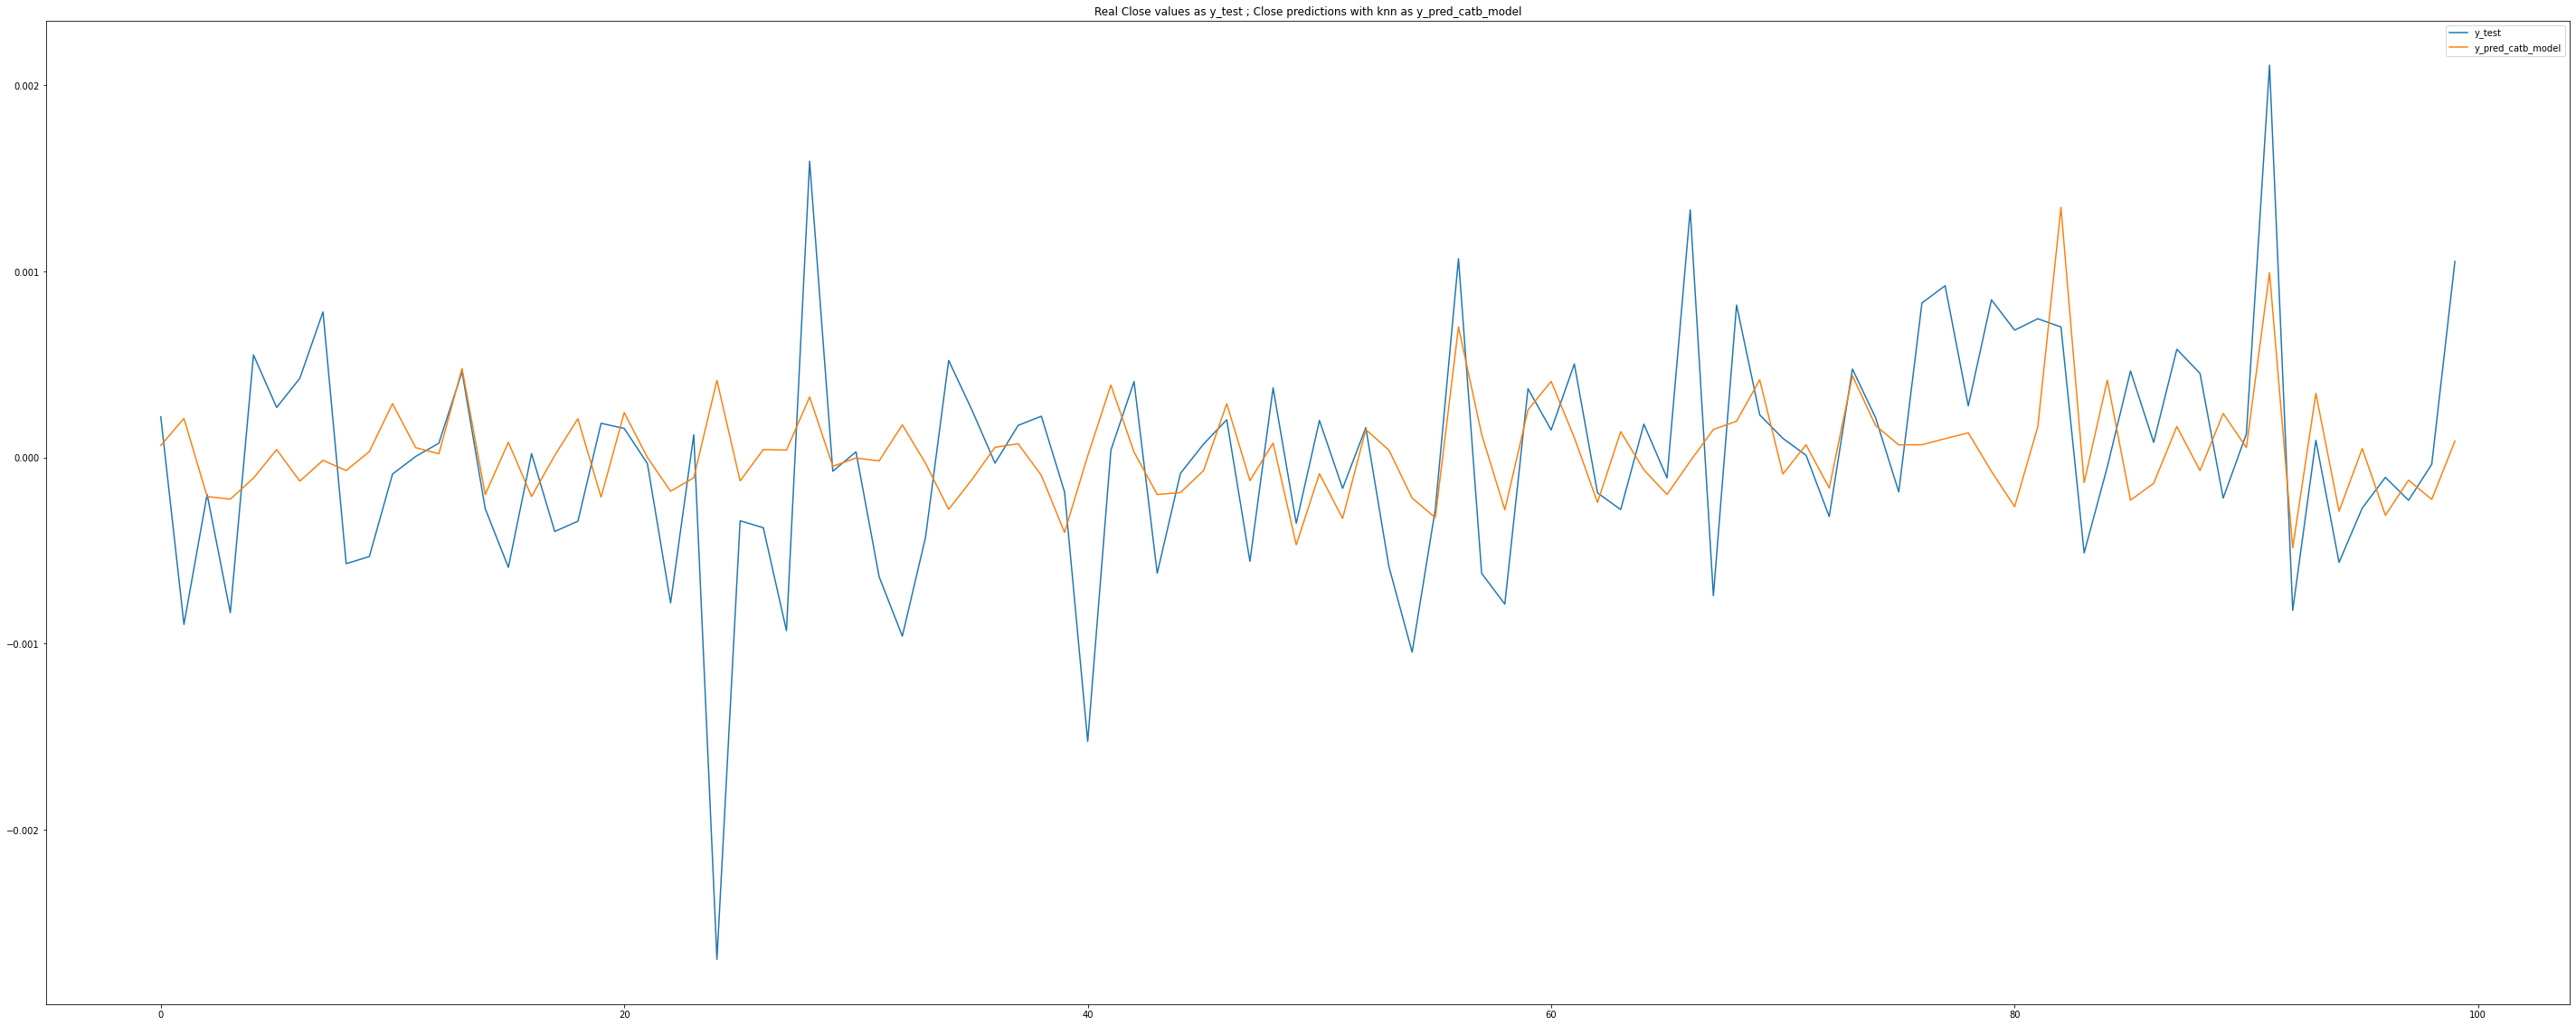

In [53]:
list_of_tuples = list(zip(y_test, y_pred_catb_model))
knn_res_df = pd.DataFrame(list_of_tuples, columns = ['y_test', 'y_pred_catb_model'])
knn_res_df[:100].plot(title ="Real Close values as y_test ; Close predictions with knn as y_pred_catb_model")

# MODEL SELECTION

In [54]:
knn_model_rmse = np.sqrt(mean_squared_error(y_test, y_pred_knn))
knn_model_mae = mean_absolute_error(y_test, y_pred_knn)

cart_model_rmse = np.sqrt(mean_squared_error(y_test, y_pred_cart))
cart_model_mae = mean_absolute_error(y_test, y_pred_cart)

bag_model_rmse = np.sqrt(mean_squared_error(y_test, y_pred_bag_model))
bag_model_mae = mean_absolute_error(y_test, y_pred_bag_model)

rf_model_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf_model))
rf_model_mae = mean_absolute_error(y_test, y_pred_rf_model)

gbm_model_rmse = np.sqrt(mean_squared_error(y_test, y_pred_gbm_model))
gbm_model_mae = mean_absolute_error(y_test, y_pred_gbm_model)

lgbm_model_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lgbm_model))
lgbm_model_mae = mean_absolute_error(y_test, y_pred_lgbm_model)

catb_model_rmse = np.sqrt(mean_squared_error(y_test, y_pred_catb_model))
catb_model_mae = mean_absolute_error(y_test, y_pred_catb_model)


In [55]:
cmp_dic = {"knn_model": [knn_model_rmse, knn_model_mae],
            "cart_model": [cart_model_rmse, cart_model_mae],
            "bag_model": [bag_model_rmse, bag_model_mae],
            "rf_model": [rf_model_rmse, rf_model_mae],
            "gbm_mmodel": [gbm_model_rmse, gbm_model_mae],
            "lgbm_model": [lgbm_model_rmse, lgbm_model_mae],
            "catb_model": [catb_model_rmse, catb_model_mae]}  

cmp_df = pd.DataFrame(cmp_dic, index = ["rmse", "mae"])
cmp_df

,knn_model,cart_model,bag_model,rf_model,gbm_mmodel,lgbm_model,catb_model
rmse,0.000640,0.001123,0.000772,0.000673,0.000748,0.000682,0.00061
mae,0.000475,0.000691,0.000490,0.000463,0.000480,0.000488,0.00044


# MODEL EVALUATION

In [56]:
catb_params = {
    "iterations": [200, 500],
    "learning_rate": [0.01, 0.05, 0.1],
    "depth": [3, 5, 8]
}

In [58]:
# catb = CatBoostRegressor()
# catb_cv_model = GridSearchCV(catb, catb_params, cv = 5, n_jobs = -1, verbose = 2)
# catb_cv_model.fit(X_train, y_train)
# catb_cv_model.best_params_

In [59]:
catb = CatBoostRegressor(iterations = 500,
                        learning_rate = 0.1,
                        depth = 3)
catb_model_tuned = catb.fit(X_train, y_train)
y_pred_catb_model_tuned = catb_model_tuned.predict(X_test)

0:	learn: 0.0006654	total: 1.11ms	remaining: 554ms
1:	learn: 0.0006612	total: 2.32ms	remaining: 577ms
2:	learn: 0.0006555	total: 3.36ms	remaining: 557ms
3:	learn: 0.0006492	total: 4.34ms	remaining: 538ms
4:	learn: 0.0006456	total: 5.38ms	remaining: 533ms
5:	learn: 0.0006398	total: 6.44ms	remaining: 530ms
6:	learn: 0.0006390	total: 7.46ms	remaining: 525ms
7:	learn: 0.0006342	total: 8.78ms	remaining: 540ms
8:	learn: 0.0006320	total: 10.4ms	remaining: 567ms
9:	learn: 0.0006291	total: 11.7ms	remaining: 574ms
10:	learn: 0.0006286	total: 12.9ms	remaining: 573ms
11:	learn: 0.0006270	total: 14ms	remaining: 570ms
12:	learn: 0.0006248	total: 15.1ms	remaining: 565ms
13:	learn: 0.0006226	total: 16.4ms	remaining: 568ms
14:	learn: 0.0006205	total: 17.4ms	remaining: 563ms
15:	learn: 0.0006171	total: 18.3ms	remaining: 554ms
16:	learn: 0.0006135	total: 19.3ms	remaining: 548ms
17:	learn: 0.0006103	total: 20.5ms	remaining: 549ms
18:	learn: 0.0006074	total: 21.8ms	remaining: 551ms
19:	learn: 0.0006053	tot

In [60]:
scale = final_df["Close_change_shifted"].values.max() - final_df["Close_change_shifted"].values.min()
print("In the interval", scale, ", performance metrics are as follows")
print("RMSE: ", np.sqrt(mean_squared_error(y_test, y_pred_catb_model_tuned)))
print("MSE: ", mean_squared_error(y_test, y_pred_catb_model_tuned))
print("MAE: ", mean_absolute_error(y_test, y_pred_catb_model_tuned))

In the interval 0.009118862234485992 , performance metrics are as follows
RMSE:  0.0006486081721857576
MSE:  4.206925610261493e-07
MAE:  0.0004596095948302235


<AxesSubplot:title={'center':'Real Close values as y_test ; Close predictions with knn as y_pred_catb_model_tuned'}>

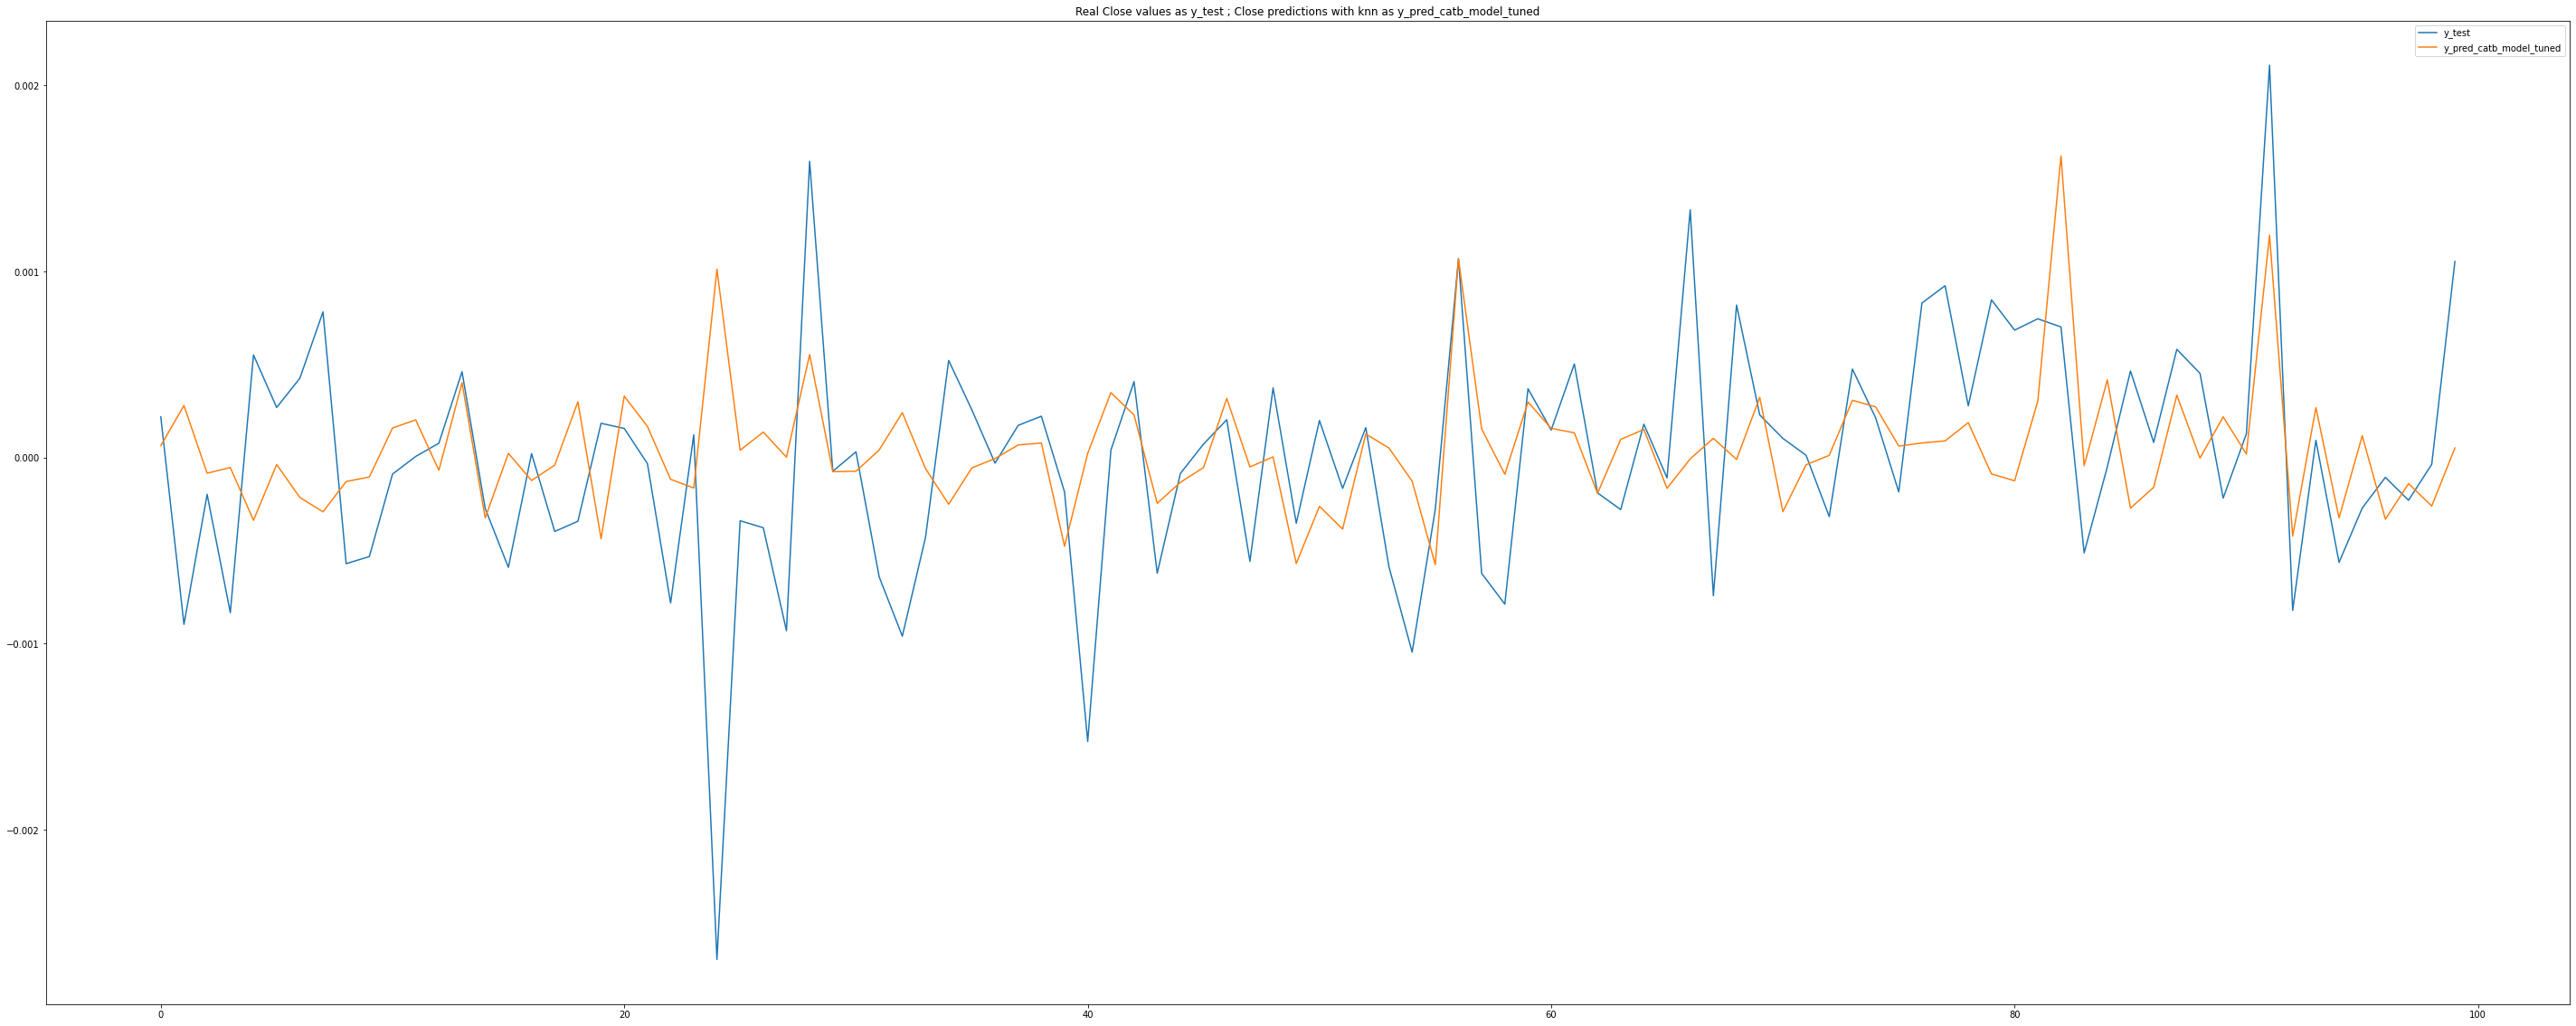

In [61]:
list_of_tuples = list(zip(y_test, y_pred_catb_model_tuned))
knn_res_df = pd.DataFrame(list_of_tuples, columns = ['y_test', 'y_pred_catb_model_tuned'])
knn_res_df[:100].plot(title ="Real Close values as y_test ; Close predictions with knn as y_pred_catb_model_tuned")

Text(0.5, 0, 'Importance of variables when predicting BTC close values 1 period after from now')

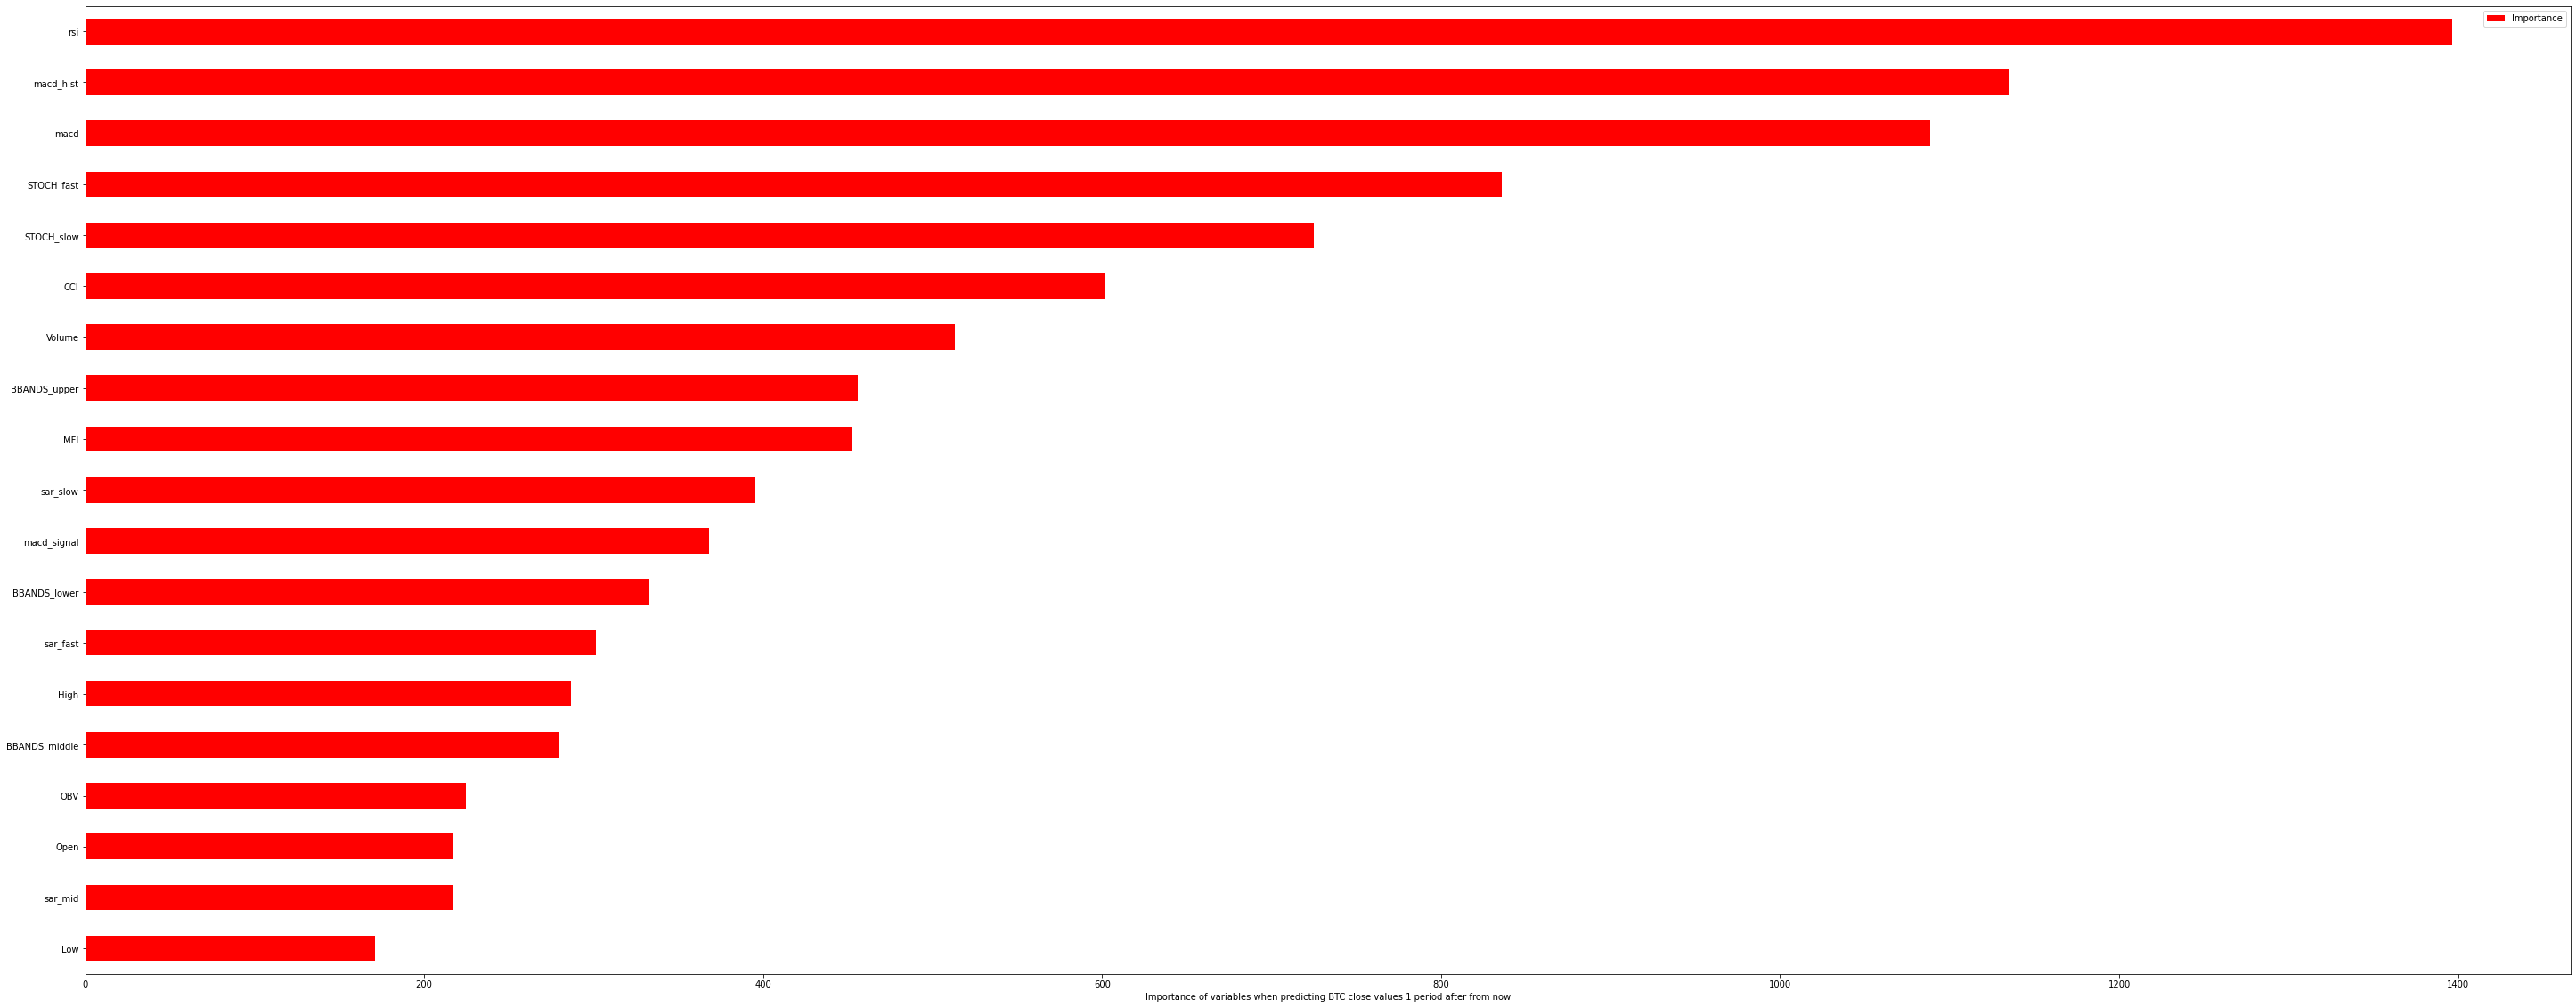

In [62]:
# Variable importance levels (percentage)
Importance = pd.DataFrame({"Importance": catb_model_tuned.feature_importances_ * 100},
                            index = X_train.columns)
Importance.sort_values(by = "Importance", axis = 0, ascending = True).plot(kind = "barh",
color = "r")

plt.xlabel("Importance of variables when predicting BTC close values 1 period after from now")

In [63]:
back_test_df = pd.DataFrame()
back_test_df["Prediction"] = y_pred_catb_model_tuned
back_test_df["Change"] = y_test.values

In [64]:
tp = 0
tn = 0
fp = 0
fn = 0

for curr_index in range(len(back_test_df["Change"])):
    curr_pred = back_test_df["Prediction"].values[curr_index]
    curr_change = back_test_df["Change"].values[curr_index]

    if curr_change >= 0:
        if curr_pred >= 0:
            tp += 1
        else:
            fn += 1
    else:
        if curr_pred >= 0:
            fp += 1
        else:
            tn += 1            
f1_score = tp / (tp + (fp/2 + fn/2))
print(tp, " ", fn)
print(fp, " ", tn)
print("f1_score: {0}".format(f1_score))

48   40
35   57
f1_score: 0.5614035087719298
